实验环境信息等内容网址：

repo: [Streamer0320/NLP-3b | GitHub](https://github.com/Streamer0320/NLP-3b/)

fork: [jin-hao-0320/NLP-3b | Gitee](https://gitee.com/jin-hao-0320/NLP-3b)

# 5. 分类和标注词汇

早在小学你就学过名词、动词、形容词和副词之间的差异。这些“词类”不是闲置的文法家的发明，而是对许多语言处理任务都有用的分类。正如我们将看到的，这些分类源于对文本中词的分布的简单的分析。本章的目的是要回答下列问题：

1. 什么是词汇分类，在自然语言处理中它们是如何使用？
2. 一个好的存储词汇和它们的分类的Python数据结构是什么？
3. 我们如何自动标注文本中词汇的词类？

一路上，我们将介绍NLP的一些基本技术，包括序列标注、N-gram模型、回退和评估。这些技术在许多方面都很有用，标注为我们提供了一个表示它们的简单的上下文。我们还将看到，在典型的NLP处理流程中，标注为何是位于分词之后的第二个步骤。

将单词按它们的词性分类并进行相应地标注的过程，称为词语性质标注、词性标注或简称标注。词性也称为词类或词汇类别。用于特定任务的标记的集合被称为一个标记集。我们在本章的重点是运用标记和自动标注文本。



<a href="#1-使用词性标注器">1 使用词性标注器</a>

<a href="#2-已经标注的语料库">2 已经标注的语料库</a>

<a href="#3-使用Python字典映射单词到其属性">3 使用Python字典映射单词到其属性</a>

<a href="#41-默认标注器">4.1 默认标注器</a>

<a href="#5-N-gram标注">5 N-gram标注</a>

<a href="#6-基于转换的标注">6 基于转换的标注</a>

<a href="#7-如何确定一个词的分类">7 如何确定一个词的分类</a>



## 1 使用词性标注器

一个词语性质标注器或者词性标注器处理一个单词序列，为每个词附加一个词性标记（不要忘记`import nltk`）：

In [2]:
from nltk import word_tokenize # 从 nltk 导入word_tokenize

text = word_tokenize("And now for something completely different")
nltk.pos_tag(text)

[('And', 'CC'),
 ('now', 'RB'),
 ('for', 'IN'),
 ('something', 'NN'),
 ('completely', 'RB'),
 ('different', 'JJ')]

在这里我们看到and是`CC`，并列连词；now和completely是`RB`，副词；for是`IN`，介词；something是`NN`，名词；different是`JJ`，形容词。

注意

NLTK为每个标记提供了文档，可以使用该标记来查询，如`nltk.help.upenn_tagset('RB')`，或者一个正则表达，如`nltk.help.upenn_tagset('NN.*')`。一些语料库有标记集文档的README文件，见`nltk.corpus.???.readme()`，用语料库的名称替换。

让我们来看看另一个例子，这次包括一些同形同音异义词：

In [3]:
text = word_tokenize("They refuse to permit us to obtain the refuse permit")
nltk.pos_tag(text)

[('They', 'PRP'),
 ('refuse', 'VBP'),
 ('to', 'TO'),
 ('permit', 'VB'),
 ('us', 'PRP'),
 ('to', 'TO'),
 ('obtain', 'VB'),
 ('the', 'DT'),
 ('refuse', 'NN'),
 ('permit', 'NN')]

请注意refuse和permit都以现在时动词（`VBP`）和名词（`NN`）形式出现。例如refUSE是一个动词，意为“拒绝”，而REFuse是一个名词，意为“垃圾”（即它们不是同音词）。因此，我们需要知道正在使用哪一个词以便能正确读出文本。（出于这个原因，文本转语音系统通常进行词性标注。）

注意

**轮到你来：** 很多单词，如ski和race，可以用作名词或动词而发音没有区别。你能想出其他的吗？提示：想想一个常见的东西，尝试把词to放到它前面，看它是否也是一个动词；或者想想一个动作，尝试把the放在它前面，看它是否也是一个名词。现在用这个词的两种用途造句，在这句话上运行词性标注器。

词汇类别如“名词”和词性标记如`NN`，看上去似乎有其用途，但在细节上将使许多读者感到晦涩。你可能想知道要引进这种额外的信息的理由是什么。很多这些类别源于对文本中单词分布的粗略分析。考虑下面的分析，涉及woman（名词），bought（动词），over（介词）和the（限定词）。`text.similar()`方法接收一个单词w，找出所有上下文w1w w2，然后找出所有出现在相同上下文中的词w'，即w1w'w2。

In [4]:
text = nltk.Text(word.lower() for word in nltk.corpus.brown.words())
text.similar('woman')

man time day year car moment world house family child country boy
state job place way war girl work word


In [5]:
text.similar('bought')

made said done put had seen found given left heard was been brought
set got that took in told felt


In [6]:
text.similar('over')

in on to of and for with from at by that into as up out down through
is all about


In [7]:
text.similar('the')

a his this their its her an that our any all one these my in your no
some other and


可以观察到，搜索woman找到名词；搜索bought找到的大部分是动词；搜索over一般会找到介词；搜索the找到几个限定词。一个标注器能够正确识别一个句子的上下文中的这些词的标记，例如The woman bought over $150,000 worth of clothes。

一个标注器还可以为我们对未知词的认识建模，例如我们可以根据词根scrobble猜测scrobbling可能是一个动词，并有可能发生在he was scrobbling这样的上下文中。

## 2 已经标注的语料库

<a href="#21-表示已经标注的词符">2.1 表示已经标注的词符</a>

<a href="#22-读取已标注的语料库">2.2 读取已标注的语料库</a>

<a href="#23-通用词性标记集">2.3 通用词性标记集</a>

<a href="#24-名词">2.4 名词</a>

<a href="#25-动词">2.5 动词</a>

<a href="#26-形容词和副词">2.6 形容词和副词</a>

<a href="#27-未简化的标记">2.7 未简化的标记</a>

<a href="#28-探索已标注的语料库">2.8 探索已标注的语料库</a>

## 2.1 表示已经标注的词符

按照NLTK的约定，一个已标注的词符使用一个由词符和标记组成的元组来表示。我们可以使用函数`str2tuple()`从表示一个已标注的词符的标准字符串创建一个这样的特殊元组：

In [8]:
tagged_token = nltk.tag.str2tuple('fly/NN') # 从表示一个已标注的词符的标准字符串创建一个特殊元组
tagged_token

('fly', 'NN')

In [9]:
tagged_token[0]

'fly'

In [10]:
tagged_token[1]

'NN'

我们可以直接从一个字符串构造一个已标注的词符的列表。第一步是对字符串分词以便能访问单独的`单词/标记`字符串，然后将每一个转换成一个元组（使用`str2tuple()`）。

In [11]:
sent = '''
The/AT grand/JJ jury/NN commented/VBD on/IN a/AT number/NN of/IN other/AP topics/NNS ,/, AMONG/IN them/PPO the/AT Atlanta/NP and/CC Fulton/NP-tl County/NN-tl purchasing/VBG departments/NNS which/WDT it/PPS said/VBD ``/`` ARE/BER well/QL operated/VBN and/CC follow/VB generally/RB accepted/VBN practices/NNS which/WDT inure/VB to/IN the/AT best/JJT interest/NN of/IN both/ABX governments/NNS ''/'' ./.
'''
[nltk.tag.str2tuple(t) for t in sent.split()]

[('The', 'AT'),
 ('grand', 'JJ'),
 ('jury', 'NN'),
 ('commented', 'VBD'),
 ('on', 'IN'),
 ('a', 'AT'),
 ('number', 'NN'),
 ('of', 'IN'),
 ('other', 'AP'),
 ('topics', 'NNS'),
 (',', ','),
 ('AMONG', 'IN'),
 ('them', 'PPO'),
 ('the', 'AT'),
 ('Atlanta', 'NP'),
 ('and', 'CC'),
 ('Fulton', 'NP-TL'),
 ('County', 'NN-TL'),
 ('purchasing', 'VBG'),
 ('departments', 'NNS'),
 ('which', 'WDT'),
 ('it', 'PPS'),
 ('said', 'VBD'),
 ('``', '``'),
 ('ARE', 'BER'),
 ('well', 'QL'),
 ('operated', 'VBN'),
 ('and', 'CC'),
 ('follow', 'VB'),
 ('generally', 'RB'),
 ('accepted', 'VBN'),
 ('practices', 'NNS'),
 ('which', 'WDT'),
 ('inure', 'VB'),
 ('to', 'IN'),
 ('the', 'AT'),
 ('best', 'JJT'),
 ('interest', 'NN'),
 ('of', 'IN'),
 ('both', 'ABX'),
 ('governments', 'NNS'),
 ("''", "''"),
 ('.', '.')]

## 2.2 读取已标注的语料库

NLTK中包括的若干语料库已标注了词性。下面是一个你用文本编辑器打开一个布朗语料库的文件就能看到的例子：

> The/at Fulton/np-tl County/nn-tl Grand/jj-tl Jury/nn-tl said/vbd Friday/nr an/at investigation/nn of/in Atlanta's/np$ recent/jj primary/nn election/nn produced/vbd `/` no/at evidence/nn ''/'' that/cs any/dti irregularities/nns took/vbd place/nn ./.

其他语料库使用各种格式存储词性标记。NLTK的语料库阅读器提供了一个统一的接口，使你不必理会这些不同的文件格式。与刚才提取并显示的上面的文件不同，布朗语料库的语料库阅读器按如下所示的方式表示数据。注意，词性标记已转换为大写的，自从布朗语料库发布以来这已成为标准的做法。

In [12]:
nltk.corpus.brown.tagged_words() # 布朗词库 tagged_words

[('The', 'AT'), ('Fulton', 'NP-TL'), ...]

In [13]:
nltk.corpus.brown.tagged_words(tagset='universal')

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

只要语料库包含已标注的文本，NLTK的语料库接口都将有一个`tagged_words()`方法。下面是一些例子，再次使用布朗语料库所示的输出格式：

In [14]:
print(nltk.corpus.nps_chat.tagged_words())

[('now', 'RB'), ('im', 'PRP'), ('left', 'VBD'), ...]


In [15]:
nltk.corpus.conll2000.tagged_words()

[('Confidence', 'NN'), ('in', 'IN'), ('the', 'DT'), ...]

In [16]:
nltk.corpus.treebank.tagged_words()

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ...]

并非所有的语料库都采用同一组标记；看前面提到的标记集的帮助函数和`readme()`方法中的文档。最初，我们想避免这些标记集的复杂化，所以我们使用一个内置的到“通用标记集“的映射：

In [17]:
nltk.corpus.brown.tagged_words(tagset='universal')

[('The', 'DET'), ('Fulton', 'NOUN'), ...]

In [18]:
nltk.corpus.treebank.tagged_words(tagset='universal')

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ...]

NLTK中还有其他几种语言的已标注语料库，包括中文，印地语，葡萄牙语，西班牙语，荷兰语和加泰罗尼亚语。这些通常含有非ASCII文本，当输出较大的结构如列表时，Python总是以十六进制显示这些。

In [19]:
nltk.corpus.sinica_treebank.tagged_words()

[('一', 'Neu'), ('友情', 'Nad'), ('嘉珍', 'Nba'), ...]

In [20]:
nltk.corpus.indian.tagged_words()

[('মহিষের', 'NN'), ('সন্তান', 'NN'), (':', 'SYM'), ...]

In [21]:
nltk.corpus.mac_morpho.tagged_words()

[('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ...]

In [22]:
nltk.corpus.conll2002.tagged_words()

[('Sao', 'NC'), ('Paulo', 'VMI'), ('(', 'Fpa'), ...]

In [23]:
nltk.corpus.cess_cat.tagged_words()

[('El', 'da0ms0'), ('Tribunal_Suprem', 'np0000o'), ...]

如果你的环境设置正确，有适合的编辑器和字体，你应该能够以人可读的方式显示单个字符串。例如，[2.1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#fig-tag-indian)显示的使用`nltk.corpus.indian`访问的数据。

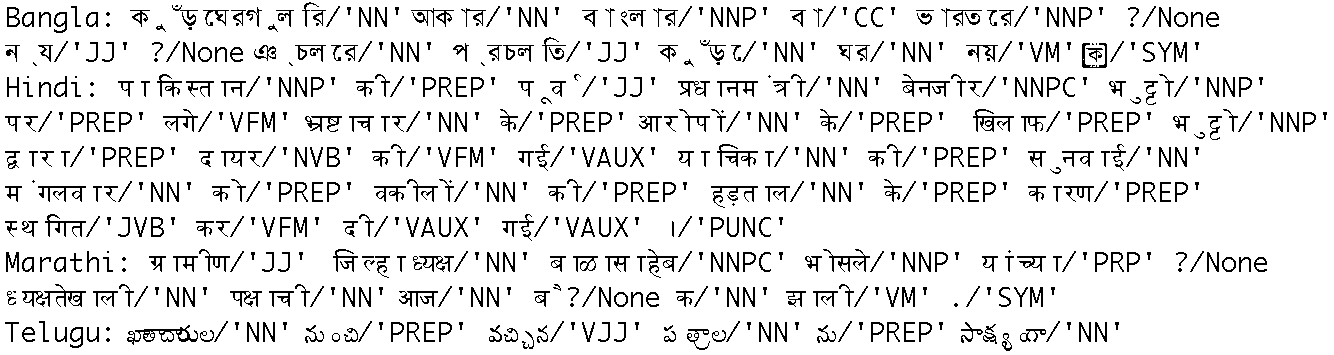)

图 2.1：四种印度语言的词性标注数据：孟加拉语、印地语、马拉地语和泰卢固语

如果语料库也被分割成句子，将有一个`tagged_sents()`方法将已标注的词划分成句子，而不是将它们表示成一个大列表。在我们开始开发自动标注器时，这将是有益的，因为它们在句子列表上被训练和测试，而不是词。

## 2.3 通用词性标记集

已标注的语料库使用许多不同的标记集约定来标注词汇。为了帮助我们开始，我们将看一看一个简化的标记集（[2.1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#tab-universal-tagset)中所示）。

表 2.1：

通用词性标记集

In [24]:
from nltk.corpus import brown
brown_news_tagged = brown.tagged_words(categories='news', tagset='universal')
tag_fd = nltk.FreqDist(tag for (word, tag) in brown_news_tagged)
tag_fd.most_common()

[('NOUN', 30654),
 ('VERB', 14399),
 ('ADP', 12355),
 ('.', 11928),
 ('DET', 11389),
 ('ADJ', 6706),
 ('ADV', 3349),
 ('CONJ', 2717),
 ('PRON', 2535),
 ('PRT', 2264),
 ('NUM', 2166),
 ('X', 92)]

注意

**轮到你来：**使用`tag_fd.plot(cumulative=True)`为上面显示的频率分布绘图。标注为上述列表中的前五个标记的词的百分比是多少？

我们可以使用这些标记做强大的搜索，结合一个图形化的词性索引工具`nltk.app.concordance()`。用它来寻找任一单词和词性标记的组合，如`N N N N`, `hit/VD`, `hit/VN`或者`the ADJ man`。

## 2.4 名词

名词一般指的是人、地点、事情或概念，例如: woman, Scotland, book, intelligence。名词可能出现在限定词和形容词之后，可以是动词的主语或宾语，如[2.2](https://usyiyi.github.io/nlp-py-2e-zh/5.html#tab-syntax-nouns)所示。

表 2.2：

一些名词的句法模式

In [25]:
word_tag_pairs = nltk.bigrams(brown_news_tagged)
noun_preceders = [a[1] for (a, b) in word_tag_pairs if b[1] == 'NOUN']
fdist = nltk.FreqDist(noun_preceders)
[tag for (tag, _) in fdist.most_common()]

['NOUN',
 'DET',
 'ADJ',
 'ADP',
 '.',
 'VERB',
 'CONJ',
 'NUM',
 'ADV',
 'PRT',
 'PRON',
 'X']

这证实了我们的断言，名词出现在限定词和形容词之后，包括数字形容词（数词，标注为`NUM`）。

## 2.5 动词

动词是用来描述事件和行动的词，例如[2.3](https://usyiyi.github.io/nlp-py-2e-zh/5.html#tab-syntax-verbs)中的fall, eat。在一个句子中，动词通常表示涉及一个或多个名词短语所指示物的关系。

表 2.3：

一些动词的句法模式

In [26]:
wsj = nltk.corpus.treebank.tagged_words(tagset='universal')
word_tag_fd = nltk.FreqDist(wsj)
[wt[0] for (wt, _) in word_tag_fd.most_common() if wt[1] == 'VERB']

['is',
 'said',
 'was',
 'are',
 'be',
 'has',
 'have',
 'will',
 'says',
 'would',
 'were',
 'had',
 'been',
 'could',
 "'s",
 'can',
 'do',
 'say',
 'make',
 'may',
 'did',
 'rose',
 'made',
 'does',
 'expected',
 'buy',
 'take',
 'get',
 'might',
 'sell',
 'added',
 'sold',
 'help',
 'including',
 'should',
 'reported',
 'according',
 'pay',
 'compared',
 'being',
 'fell',
 'began',
 'based',
 'used',
 'closed',
 "'re",
 'want',
 'see',
 'took',
 'yield',
 'offered',
 'set',
 'priced',
 'approved',
 'come',
 'noted',
 'cut',
 'ended',
 'found',
 'increased',
 'become',
 'think',
 'named',
 'go',
 'trying',
 'proposed',
 'received',
 'growing',
 'declined',
 'held',
 'give',
 'came',
 'use',
 'put',
 'making',
 'continue',
 'raise',
 'estimated',
 'called',
 'paid',
 'designed',
 'going',
 'expects',
 'seeking',
 'must',
 'plans',
 'wo',
 'increasing',
 'saying',
 'got',
 'owns',
 'trading',
 'acquired',
 'gained',
 'fined',
 'reached',
 'holding',
 'announced',
 'filed',
 'became',


请注意，频率分布中计算的项目是词-标记对。由于词汇和标记是成对的，我们可以把词作作为条件，标记作为事件，使用条件-事件对的链表初始化一个条件频率分布。这让我们看到了一个给定的词的标记的频率顺序列表：

In [27]:
cfd1 = nltk.ConditionalFreqDist(wsj)
cfd1['yield'].most_common()

[('VERB', 28), ('NOUN', 20)]

In [28]:
cfd1['cut'].most_common()

[('VERB', 25), ('NOUN', 3)]

我们可以颠倒配对的顺序，这样标记作为条件，词汇作为事件。现在我们可以看到对于一个给定的标记可能的词。我们将用《华尔街日报 》的标记集而不是通用的标记集来这样做：

In [29]:
wsj = nltk.corpus.treebank.tagged_words()
cfd2 = nltk.ConditionalFreqDist((tag, word) for (word, tag) in wsj)
list(cfd2['VBN'])

['been',
 'expected',
 'made',
 'compared',
 'based',
 'used',
 'priced',
 'sold',
 'named',
 'designed',
 'held',
 'fined',
 'taken',
 'paid',
 'traded',
 'increased',
 'said',
 'filed',
 'reached',
 'called',
 'scheduled',
 'disclosed',
 'reported',
 'proposed',
 'estimated',
 'set',
 'known',
 'built',
 'approved',
 'given',
 'acquired',
 'found',
 'offered',
 'received',
 'caused',
 'considered',
 'ordered',
 'required',
 'preferred',
 'led',
 'issued',
 'fixed',
 'listed',
 'prepared',
 'involved',
 'aimed',
 'needed',
 'launched',
 'produced',
 'put',
 'planned',
 'seen',
 'alleged',
 'valued',
 'barred',
 'become',
 'related',
 'improved',
 'changed',
 'provided',
 'come',
 'got',
 'allowed',
 'mixed',
 'suspended',
 'owned',
 'elected',
 'worried',
 'completed',
 'combined',
 'raised',
 'left',
 'placed',
 'invested',
 'fallen',
 'failed',
 'helped',
 'run',
 'opposed',
 'quoted',
 'continued',
 'threatened',
 'offset',
 'shipped',
 'eliminated',
 'followed',
 'sought',
 'hurt'

要弄清`VBD`（过去式）和`VBN`（过去分词）之间的区别，让我们找到可以同是`VBD`和`VBN`的词汇，看看一些它们周围的文字：

In [30]:
[w for w in cfd1.conditions() if 'VBD' in cfd1[w] and 'VBN' in cfd1[w]]

[]

In [31]:
idx1 = wsj.index(('kicked', 'VBD'))
wsj[idx1-4:idx1+1]

[('While', 'IN'),
 ('program', 'NN'),
 ('trades', 'NNS'),
 ('swiftly', 'RB'),
 ('kicked', 'VBD')]

In [32]:
idx2 = wsj.index(('kicked', 'VBN'))
wsj[idx2-4:idx2+1]

[('head', 'NN'),
 ('of', 'IN'),
 ('state', 'NN'),
 ('has', 'VBZ'),
 ('kicked', 'VBN')]

在这种情况下，我们可以看到过去分词kicked前面是助动词have的形式。这是普遍真实的吗？

注意

**轮到你来：** 通过`list(cfd2['VN'])`指定一个过去分词的列表，尝试收集所有直接在列表中项目前面的词-标记对。

## 2.6 形容词和副词

另外两个重要的词类是形容词和副词。形容词修饰名词，可以作为修饰语（如the large pizza中的large），或者谓语（如the pizza is large）。英语形容词可以有内部结构（如the falling stocks中的fall+ing）。副词修饰动词，指定动词描述的事件的时间、方式、地点或方向（如the stocks fell quickly中的quickly）。副词也可以修饰的形容词（如Mary's teacher was really nice中的really）。

英语中还有几个封闭的词类，如介词，冠词（也常称为限定词）（如the、a），情态动词（如should、may）和人称代词（如she、they）。每个词典和语法对这些词的分类都不同。

注意

**轮到你来：**如果你对这些词性中的一些不确定，使用`nltk.app.concordance()`学习它们，或看*Schoolhouse Rock!*语法视频于YouTube，或者查询本章结束的进一步阅读一节。

## 2.7 未简化的标记

让我们找出每个名词类型中最频繁的名词。[2.2](https://usyiyi.github.io/nlp-py-2e-zh/5.html#code-findtags)中的程序找出所有以`NN`开始的标记，并为每个标记提供了几个示例单词。你会看到有许多`NN`的变种；最重要有`$`表示所有格名词，`S`表示复数名词（因为复数名词通常以s结尾），以及`P`表示专有名词。此外，大多数的标记都有后缀修饰符：`-NC`表示引用，`-HL`表示标题中的词，`-TL`表示标题（布朗标记的特征）。

In [33]:
def findtags(tag_prefix, tagged_text):
    cfd = nltk.ConditionalFreqDist((tag, word) for (word, tag) in tagged_text if tag.startswith(tag_prefix))
    return dict((tag, cfd[tag].most_common(5)) for tag in cfd.conditions())

tagdict = findtags('NN', nltk.corpus.brown.tagged_words(categories='news'))
for tag in sorted(tagdict):
   print(tag, tagdict[tag])


NN [('year', 137), ('time', 97), ('state', 88), ('week', 85), ('man', 72)]
NN$ [("year's", 13), ("world's", 8), ("state's", 7), ("nation's", 6), ("city's", 6)]
NN$-HL [("Golf's", 1), ("Navy's", 1)]
NN$-TL [("President's", 11), ("Administration's", 3), ("Army's", 3), ("League's", 3), ("University's", 3)]
NN-HL [('sp.', 2), ('problem', 2), ('Question', 2), ('cut', 2), ('party', 2)]
NN-NC [('ova', 1), ('eva', 1), ('aya', 1)]
NN-TL [('President', 88), ('House', 68), ('State', 59), ('University', 42), ('City', 41)]
NN-TL-HL [('Fort', 2), ('Mayor', 1), ('Commissioner', 1), ('City', 1), ('Oak', 1)]
NNS [('years', 101), ('members', 69), ('people', 52), ('sales', 51), ('men', 46)]
NNS$ [("children's", 7), ("women's", 5), ("men's", 3), ("janitors'", 3), ("taxpayers'", 2)]
NNS$-HL [("Dealers'", 1), ("Idols'", 1)]
NNS$-TL [("Women's", 4), ("States'", 3), ("Giants'", 2), ("Princes'", 1), ("Bombers'", 1)]
NNS-HL [('Wards', 1), ('deputies', 1), ('bonds', 1), ('aspects', 1), ('Decisions', 1)]
NNS-TL [

当我们开始在本章后续部分创建词性标注器时，我们将使用未简化的标记。

## 2.8 探索已标注的语料库

让我们简要地回过来探索语料库，我们在前面的章节中看到过，这次我们探索词性标记。

假设我们正在研究词often，想看看它是如何在文本中使用的。我们可以试着看看跟在often后面的词汇

In [34]:
brown_learned_text = brown.words(categories='learned')
sorted(set(b for (a, b) in nltk.bigrams(brown_learned_text) if a == 'often'))

[',',
 '.',
 'accomplished',
 'analytically',
 'appear',
 'apt',
 'associated',
 'assuming',
 'became',
 'become',
 'been',
 'began',
 'call',
 'called',
 'carefully',
 'chose',
 'classified',
 'colorful',
 'composed',
 'contain',
 'differed',
 'difficult',
 'encountered',
 'enough',
 'equate',
 'extremely',
 'found',
 'happens',
 'have',
 'ignored',
 'in',
 'involved',
 'more',
 'needed',
 'nightly',
 'observed',
 'of',
 'on',
 'out',
 'quite',
 'represent',
 'responsible',
 'revamped',
 'seclude',
 'set',
 'shortened',
 'sing',
 'sounded',
 'stated',
 'still',
 'sung',
 'supported',
 'than',
 'to',
 'when',
 'work']

然而，使用`tagged_words()`方法查看跟随词的词性标记可能更有指导性：

In [35]:
brown_lrnd_tagged = brown.tagged_words(categories='learned', tagset='universal')
tags = [b[1] for (a, b) in nltk.bigrams(brown_lrnd_tagged) if a[0] == 'often']
fd = nltk.FreqDist(tags)
fd.tabulate()

VERB  ADV  ADP  ADJ    .  PRT 
  37    8    7    6    4    2 


请注意often后面最高频率的词性是动词。名词从来没有在这个位置出现（在这个特别的语料中）。

接下来，让我们看一些较大范围的上下文，找出涉及特定标记和词序列的词（在这种情况下，`"<Verb> to <Verb>"`）。在code-three-word-phrase中，我们考虑句子中的每个三词窗口 [# 1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#three-word)，检查它们是否符合我们的标准 [# 2](https://usyiyi.github.io/nlp-py-2e-zh/5.html#verb-to-verb)。如果标记匹配，我们输出对应的词 [# 3](https://usyiyi.github.io/nlp-py-2e-zh/5.html#print-words)。

In [36]:
from nltk.corpus import brown
def process(sentence):
    for (w1,t1), (w2,t2), (w3,t3) in nltk.trigrams(sentence): 
        if (t1.startswith('V') and t2 == 'TO' and t3.startswith('V')): 
            print(w1, w2, w3) 

for tagged_sent in brown.tagged_sents():
   process(tagged_sent)

combined to achieve
continue to place
serve to protect
wanted to wait
allowed to place
expected to become
expected to approve
expected to make
intends to make
seek to set
like to see
designed to provide
get to hear
expects to tell
expected to give
prefer to pay
required to obtain
permitted to teach
designed to reduce
Asked to elaborate
got to go
raised to pay
scheduled to go
cut to meet
needed to meet
hastened to add
found to prevent
continue to insist
compelled to make
made to remove
revamped to give
want to risk
appear to spark
fails to consider
plans to call
going to examine
plans to name
come to pass
voted to accept
happens to hold
authorized to adopt
hesitated to prosecute
try to make
decided to spend
taken to preserve
left to preserve
stand to bring
decided to seek
trying to induce
proposing to make
decided to run
directed to investigate
expected to pass
expected to make
expected to encounter
hopes to pass
came to pay
expected to receive
understood to follow
wanted to vote
decide

used to attack
continued to threaten
decide to build
used to destroy
going to develop
put to see
fail to develop
seem to fall
serve to emphasize
tend to stamp
fail to enter
rehearing to acquire
fail to convey
needed to attain
seem to reduce
continue to show
sponsored to win
invited to judge
asked to pick
qualified to judge
helping to create
qualified to win
continuing to donate
found to take
built to accommodate
bothered to make
wanted to purchase
managing to get
formed to develop
used to indicate
meant to pertain
designed to cater
equipped to handle
pulled to clear
Tend to make
progresses to insure
Endeavor to get
used to separate
used to separate
seems to know
wanted to trot
likes to trot
wants to trot
started to pace
starting to go
expected to race
designed to push
looks to run
began to motor
trained to drag
fled to make
seemed to know
used to say
preferred to get
hope to cover
want to miss
scheduled to vanish
vanish to make
continued to live
seem to cascade
forget to buy
fail to sh

began to trail
began to fly
tried to calm
inspired to complete
began to talk
compelled to spend
expected to carry
tend to make
liked to think
trying to emulate
wanted to know
seemed to remember
asked to yield
made to look
begun to lose
failed to learn
wanted to take
writing to devote
vowed to kneel
hoping to lift
forced to seek
continue to urge
prepared to assist
hope to make
continue to maintain
scheduled to go
taken to program
begun to probe
attempting to present
instructed to burn
attempted to conclude
equipped to handle
trying to check
mean to write
wished to pursue
refused to attend
decided to dance
failed to amaze
continued to search
threatening to swallow
pleased to see
tried to discover
disturbed to find
failed to realize
manage to get
wanted to buy
decided to bypass
allowed to preach
allowed to pass
dared to drop
expected to move
means to ridicule
hesitate to sacrifice
forced to move
taken to effect
hoped to imprint
tailored to fit
obliged to describe
tried to block
chosen to 

italicized to guide
seems to center
operate to center
serves to focus
purport to represent
hesitates to suggest
mentioned to make
trying to develop
compelled to omit
continue to show
planning to use
expecting to recover
meant to move
preferred to continue
trying to find
planned to exterminate
trying to marry
pledged to hold
determined to create
seemed to assure
attempted to marry
obliged to concede
expected to democratize
Failing to heed
determined to keep
tend to procrastinate
even to repudiate
served to minimize
encouraged to state
trying to unearth
decided to remove
decide to encourage
prefer to hire
go to work
intended to provide
continues to stress
encouraged to adopt
motivated to take
expected to respond
training to meet
used to pay
taken to indicate
afford to trade
afford to lose
taken to exemplify
Try to imagine
trying to outfox
trying to get
invited to try
try to imagine
begin to affect
tend to move
required to pay
seek to force
act to accentuate
begin to edge
move to restrain

asked to speak
pacing to stare
wished to make
began to build
needed to carry
meaning to live
agreed to help
agreed to take
contract to let
refused to believe
meant to invade
going to turn
got to intercept
permitted to go
failed to anticipate
needed to make
use to make
help to repel
seems to shield
pretending to sleep
threatening to report
seem to concentrate
want to give
trying to pull
adjusted to operate
like to see
bent to observe
forced to accompany
fear to tread
programed to compute
remember to program
directed to develop
schooled to examine
appeared to require
encouraged to develop
remembered to introduce
guided to make
tried to run
tried to tell
tried to ask
want to ask
going to come
going to happen
going to happen
going to take
inclined to think
manage to follow
wanting to tell
tried to write
exhausted to stay
afford to lose
afford to pay
used to work
going to give
began to rock
tried to call
stoop to catch
began to paw
began to nod
hate to leave
want to leave
groped to reassemb

最后，让我们看看与它们的标记关系高度模糊不清的词。了解为什么要标注这样的词是因为它们各自的上下文可以帮助我们弄清楚标记之间的区别。

In [37]:
brown_news_tagged = brown.tagged_words(categories='news', tagset='universal')
data = nltk.ConditionalFreqDist((word.lower(), tag) for (word, tag) in brown_news_tagged)
for word in sorted(data.conditions()):
   if len(data[word]) > 3:
       tags = [tag for (tag, _) in data[word].most_common()]
       print(word, ' '.join(tags))


best ADJ ADV VERB NOUN
close ADV ADJ VERB NOUN
open ADJ VERB NOUN ADV
present ADJ ADV NOUN VERB
that ADP DET PRON ADV


注意

**轮到你来：**打开词性索引工具`nltk.app.concordance()`并加载完整的布朗语料库（简化标记集）。现在挑选一些上面代码例子末尾处列出的词，看看词的标记如何与词的上下文相关。例如搜索`near`会看到所有混合在一起的形式，搜索`near/ADJ`会看到它作为形容词使用，`near N`会看到只是名词跟在后面的情况，等等。更多的例子，请修改附带的代码，以便它列出的词具有三个不同的标签。

## 3 使用Python字典映射单词到其属性

正如我们已经看到，`(word, tag)`形式的一个已标注词是词和词性标记的关联。一旦我们开始做词性标注，我们将会创建分配一个标记给一个词的程序，标记是在给定上下文中最可能的标记。我们可以认为这个过程是从词到标记的映射。在Python中最自然的方式存储映射是使用所谓的字典数据类型（在其他的编程语言又称为关联数组或哈希数组）。在本节中，我们来看看字典，看它如何能表示包括词性在内的各种不同的语言信息。



<a href="#31-索引列表vs字典">3.1 索引列表VS字典</a>

<a href="#33-定义字典">3.3 定义字典</a>

<a href="#34-默认字典">3.4 默认字典</a>

<a href="#35-递增地更新字典">3.5 递增地更新字典</a>

<a href="#36-复杂的键和值">3.6 复杂的键和值</a>

<a href="#37-反转字典">3.7 反转字典</a>



## 3.1 索引列表VS字典

我们已经看到，文本在Python中被视为一个词列表。链表的一个重要的属性是我们可以通过给出其索引来“看”特定项目，例如`text1[100]`。请注意我们如何指定一个数字，然后取回一个词。我们可以把链表看作一种简单的表格，如 [3.1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#fig-maps01)所示。

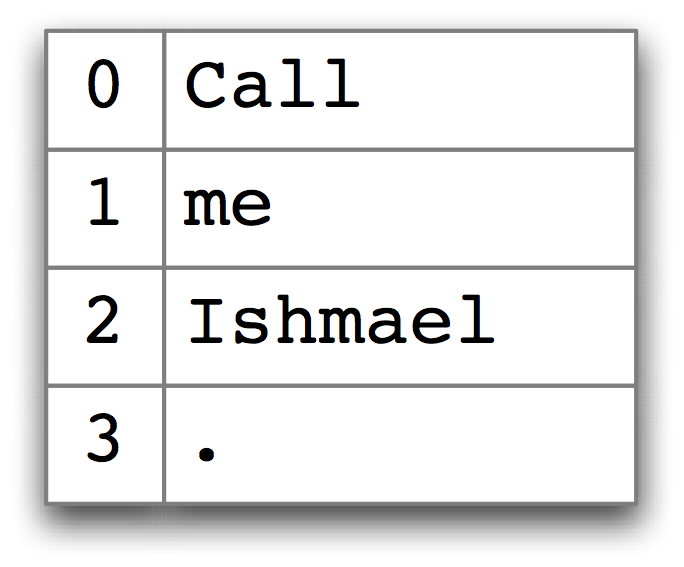

图 3.1：列表查找：一个整数索引帮助我们访问Python列表的内容。

对比这种情况与频率分布（[3](https://usyiyi.github.io/nlp-py-2e-zh/1.html#sec-computing-with-language-simple-statistics)），在那里我们指定一个词然后取回一个数字，如`fdist['monstrous']`，它告诉我们一个给定的词在文本中出现的次数。用词查询对任何使用过字典的人都很熟悉。[3.2](https://usyiyi.github.io/nlp-py-2e-zh/5.html#fig-maps02)展示一些更多的例子。


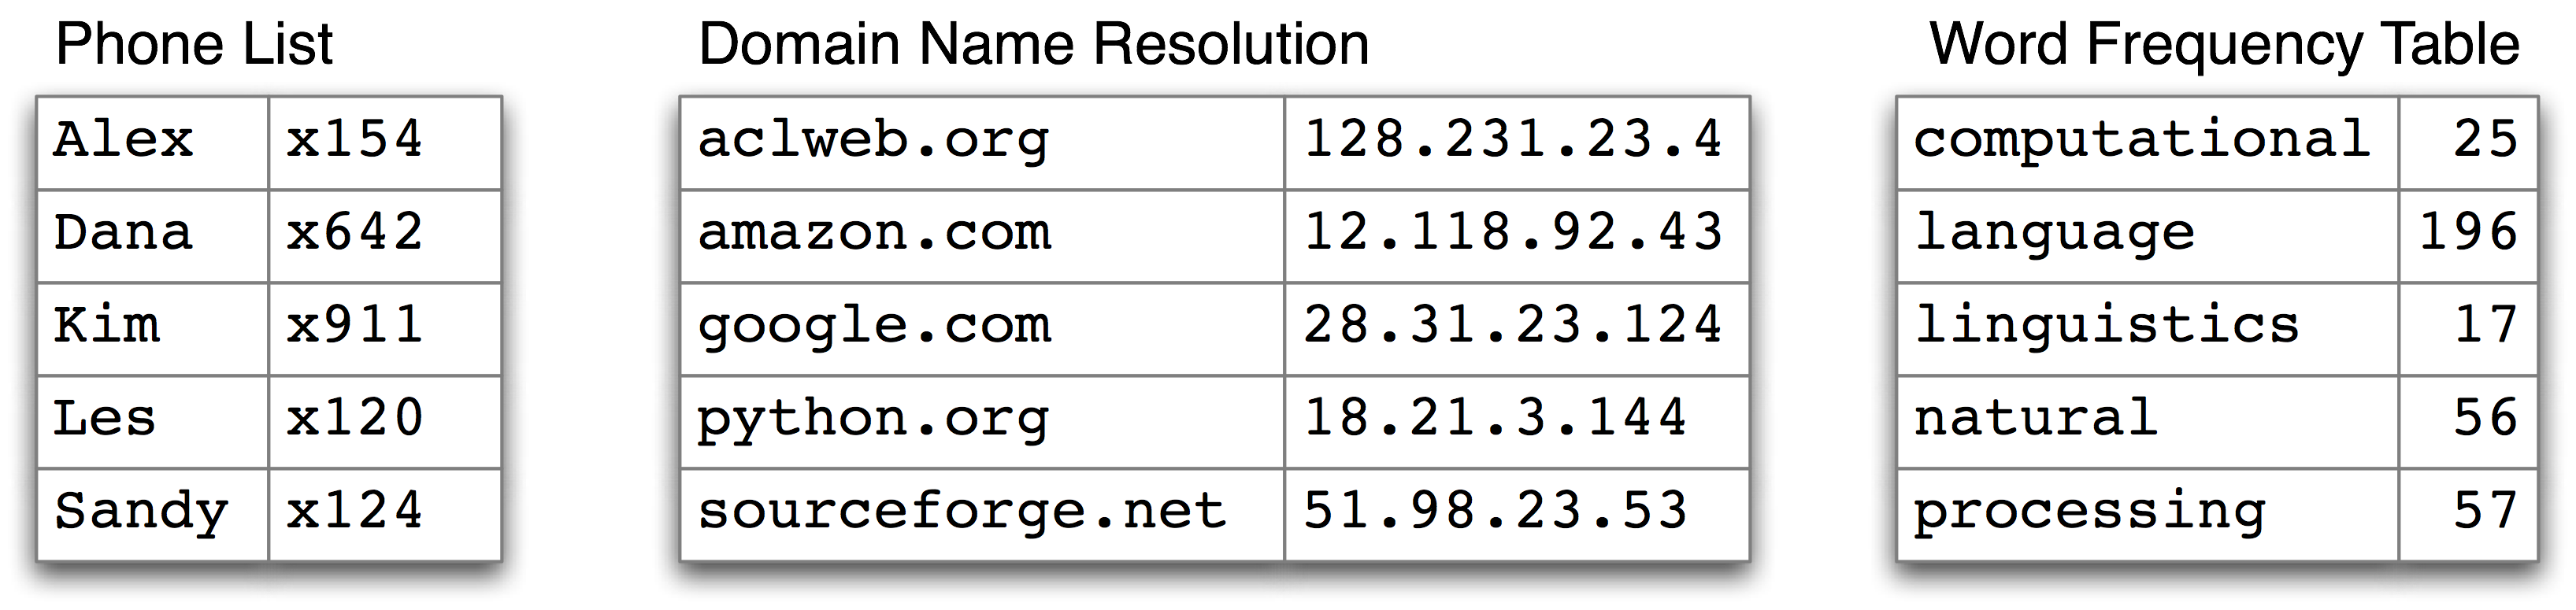

图 3.2：字典查询：我们使用一个关键字，如某人的名字、一个域名或一个英文单词，访问一个字典的条目；字典的其他名字有映射、哈希表、哈希和关联数组。

在电话簿中，我们用名字查找一个条目得到一个数字。当我们在浏览器中输入一个域名，计算机查找它得到一个IP 地址。一个词频表允许我们查一个词找出它在一个文本集合中的频率。在所有这些情况中，我们都是从名称映射到数字，而不是其他如列表那样的方式。总之，我们希望能够在任意类型的信息之间映射。[3.1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#tab-linguistic-objects)列出了各种语言学对象以及它们的映射。

表 3.1：

语言学对象从键到值的映射

In [2]:
pos = {}
pos

{}

In [3]:
pos['colorless'] = 'ADJ' 
pos

{'colorless': 'ADJ'}

In [4]:
pos['ideas'] = 'N'
pos['sleep'] = 'V'
pos['furiously'] = 'ADV'
pos 

{'colorless': 'ADJ', 'ideas': 'N', 'sleep': 'V', 'furiously': 'ADV'}

所以，例如， [# 1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#pos-colorless)说的是colorless的词性是形容词，或者更具体地说：在字典`pos`中，键`'colorless'`被分配了值`'ADJ'`。当我们检查`pos`的值时 [# 2](https://usyiyi.github.io/nlp-py-2e-zh/5.html#pos-inspect)，我们看到一个键-值对的集合。一旦我们以这样的方式填充了字典，就可以使用键来检索值：

In [5]:
pos['ideas']

'N'

In [6]:
pos['colorless']

'ADJ'

当然，我们可能会无意中使用一个尚未分配值的键。

In [7]:
pos['green']

KeyError: 'green'

这就提出了一个重要的问题。与列表和字符串不同，我们可以用`len()`算出哪些整数是合法索引，我们如何算出一个字典的合法键？如果字典不是太大，我们可以简单地通过查看变量`pos`检查它的内容。正如在前面（ [# 2](https://usyiyi.github.io/nlp-py-2e-zh/5.html#pos-inspect)行）所看到，这为我们提供了键-值对。请注意它们的顺序与最初放入它们的顺序不同；这是因为字典不是序列而是映射（参见[3.2](https://usyiyi.github.io/nlp-py-2e-zh/5.html#fig-maps02)），键没有固定地排序。

换种方式，要找到键，我们可以将字典转换成一个列表 [# 1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#dict-to-list)——要么在期望列表的上下文中使用字典，如作为`sorted()`的参数 [# 2](https://usyiyi.github.io/nlp-py-2e-zh/5.html#dict-sorted)，要么在`for` 循环中 [# 3](https://usyiyi.github.io/nlp-py-2e-zh/5.html#dict-for-loop)。

In [8]:
list(pos) 

['colorless', 'ideas', 'sleep', 'furiously']

In [9]:
sorted(pos) 

['colorless', 'furiously', 'ideas', 'sleep']

In [10]:
[w for w in pos if w.endswith('s')] 

['colorless', 'ideas']

注意

当你输入`list(pos)`时，你看到的可能会与这里显示的顺序不同。如果你想看到有序的键，只需要对它们进行排序。

与使用一个`for`循环遍历字典中的所有键一样，我们可以使用`for`循环输出列表：

In [11]:
for word in sorted(pos):
   print(word + ":", pos[word])

colorless: ADJ
furiously: ADV
ideas: N
sleep: V


最后，字典的方法`keys()`、`values()`和`items()`允许我们以单独的列表访问键、值以及键-值对。我们甚至可以排序元组 [# 1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#sort-tuples)，按它们的第一个元素排序（如果第一个元素相同，就使用它们的第二个元素）。

In [12]:
list(pos.keys())

['colorless', 'ideas', 'sleep', 'furiously']

In [13]:
list(pos.values())

['ADJ', 'N', 'V', 'ADV']

In [14]:
list(pos.items())

[('colorless', 'ADJ'), ('ideas', 'N'), ('sleep', 'V'), ('furiously', 'ADV')]

In [15]:
for key, val in sorted(pos.items()): 
   print(key + ":", val)

colorless: ADJ
furiously: ADV
ideas: N
sleep: V


我们要确保当我们在字典中查找某词时，一个键只得到一个值。现在假设我们试图用字典来存储可同时作为动词和名词的词sleep：

In [16]:
pos['sleep'] = 'V'
pos['sleep']

'V'

In [17]:
pos['sleep'] = 'N'
pos['sleep']

'N'

最初，`pos['sleep']`给的值是`'V'`。但是，它立即被一个新值`'N'`覆盖。换句话说，字典中只能有`'sleep'`的一个条目。然而，有一个方法可以在该项目中存储多个值：我们使用一个列表值，例如`pos['sleep'] = ['N', 'V']`。事实上，这就是我们在[4](https://usyiyi.github.io/nlp-py-2e-zh/2.html#sec-lexical-resources)中看到的CMU发音字典，它为一个词存储多个发音。

## 3.3 定义字典

我们可以使用键-值对格式创建字典。有两种方式做这个，我们通常会使用第一个：

In [18]:
pos = {'colorless': 'ADJ', 'ideas': 'N', 'sleep': 'V', 'furiously': 'ADV'}
pos = dict(colorless='ADJ', ideas='N', sleep='V', furiously='ADV')

请注意，字典的键必须是不可改变的类型，如字符串和元组。如果我们尝试使用可变键定义字典会得到一个`TypeError`：

In [19]:
pos = {['ideas', 'blogs', 'adventures']: 'N'}

TypeError: unhashable type: 'list'

## 3.4 默认字典

如果我们试图访问一个不在字典中的键，会得到一个错误。然而，如果一个字典能为这个新键自动创建一个条目并给它一个默认值，如0或者一个空链表，将是有用的。由于这个原因，可以使用一种特殊的称为`defaultdict`的字典。为了使用它，我们必须提供一个参数，用来创建默认值，如`int`, `float`, `str`, `list`, `dict`, `tuple`。

In [20]:
from collections import defaultdict
frequency = defaultdict(int)
frequency['colorless'] = 4
frequency['ideas']

0

In [21]:
pos = defaultdict(list)
pos['sleep'] = ['NOUN', 'VERB']
pos['ideas']

[]

注意

这些默认值实际上是将其他对象转换为指定类型的函数（例如`int("2")`, `list("2")`）。当它们不带参数被调用时——`int()`, `list()`——它们分别返回`0`和`[]` 。

前面的例子中指定字典项的默认值为一个特定的数据类型的默认值。然而，也可以指定任何我们喜欢的默认值，只要提供可以无参数的被调用产生所需值的函数的名子。让我们回到我们的词性的例子，创建一个任一条目的默认值是`'N'`的字典 [# 1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#default-noun)。当我们访问一个不存在的条目时 [# 2](https://usyiyi.github.io/nlp-py-2e-zh/5.html#non-existent)，它会自动添加到字典 [# 3](https://usyiyi.github.io/nlp-py-2e-zh/5.html#automatically-added)。

In [22]:
pos = defaultdict(lambda: 'NOUN') 
pos['colorless'] = 'ADJ'
pos['blog'] 

'NOUN'

In [23]:
list(pos.items())

[('colorless', 'ADJ'), ('blog', 'NOUN')]

注意

上面的例子使用一个lambda表达式，在[4.4](https://usyiyi.github.io/nlp-py-2e-zh/4.html#sec-functions)介绍过。这个lambda表达式没有指定参数，所以我们用不带参数的括号调用它。因此，下面的`f`和`g`的定义是等价的：

In [24]:
f = lambda: 'NOUN'
f()

'NOUN'

In [25]:
def g():
   return 'NOUN'
g()

'NOUN'

让我们来看看默认字典如何被应用在较大规模的语言处理任务中。许多语言处理任务——包括标注——费很大力气来正确处理文本中只出现过一次的词。如果有一个固定的词汇和没有新词会出现的保证，它们会有更好的表现。在一个默认字典的帮助下，我们可以预处理一个文本，替换低频词汇为一个特殊的“超出词汇表”词符`UNK`。（你能不看下面的想出如何做吗？）

我们需要创建一个默认字典，映射每个词为它们的替换词。最频繁的n个词将被映射到它们自己。其他的被映射到`UNK`。

In [28]:
import nltk # 由于图片内嵌问题而重新引入 nltk，如果之前 import nltk 未中断则不需要此步骤

alice = nltk.corpus.gutenberg.words('carroll-alice.txt')
vocab = nltk.FreqDist(alice)
v1000 = [word for (word, _) in vocab.most_common(1000)]
mapping = defaultdict(lambda: 'UNK')
for v in v1000:
   mapping[v] = v

alice2 = [mapping[v] for v in alice]
alice2[:100]

['[',
 'Alice',
 "'",
 's',
 'Adventures',
 'in',
 'Wonderland',
 'by',
 'UNK',
 'UNK',
 'UNK',
 'UNK',
 'CHAPTER',
 'I',
 '.',
 'Down',
 'the',
 'Rabbit',
 '-',
 'UNK',
 'Alice',
 'was',
 'beginning',
 'to',
 'get',
 'very',
 'tired',
 'of',
 'sitting',
 'by',
 'her',
 'sister',
 'on',
 'the',
 'bank',
 ',',
 'and',
 'of',
 'having',
 'nothing',
 'to',
 'do',
 ':',
 'once',
 'or',
 'twice',
 'she',
 'had',
 'peeped',
 'into',
 'the',
 'book',
 'her',
 'sister',
 'was',
 'reading',
 ',',
 'but',
 'it',
 'had',
 'no',
 'pictures',
 'or',
 'UNK',
 'in',
 'it',
 ',',
 "'",
 'and',
 'what',
 'is',
 'the',
 'use',
 'of',
 'a',
 'book',
 ",'",
 'thought',
 'Alice',
 "'",
 'without',
 'pictures',
 'or',
 'conversation',
 "?'",
 'So',
 'she',
 'was',
 'considering',
 'in',
 'her',
 'own',
 'mind',
 '(',
 'as',
 'well',
 'as',
 'she',
 'could',
 ',']

In [29]:
len(set(alice2))

1001

## 3.5 递增地更新字典

我们可以使用字典计数出现的次数，模拟[fig-tally](https://usyiyi.github.io/nlp-py-2e-zh/1.html#fig-tally)所示的计数词汇的方法。首先初始化一个空的`defaultdict`，然后处理文本中每个词性标记。如果标记以前没有见过，就默认计数为零。每次我们遇到一个标记，就使用`+=`运算符递增它的计数。

In [30]:
from collections import defaultdict
counts = defaultdict(int)
from nltk.corpus import brown
for (word, tag) in brown.tagged_words(categories='news', tagset='universal'):
   counts[tag] += 1

counts['NOUN']

30654

In [31]:
sorted(counts)

['.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X']

In [32]:
from operator import itemgetter
sorted(counts.items(), key=itemgetter(1), reverse=True)

[('NOUN', 30654),
 ('VERB', 14399),
 ('ADP', 12355),
 ('.', 11928),
 ('DET', 11389),
 ('ADJ', 6706),
 ('ADV', 3349),
 ('CONJ', 2717),
 ('PRON', 2535),
 ('PRT', 2264),
 ('NUM', 2166),
 ('X', 92)]

In [33]:
[t for t, c in sorted(counts.items(), key=itemgetter(1), reverse=True)]

['NOUN',
 'VERB',
 'ADP',
 '.',
 'DET',
 'ADJ',
 'ADV',
 'CONJ',
 'PRON',
 'PRT',
 'NUM',
 'X']

[3.3](https://usyiyi.github.io/nlp-py-2e-zh/5.html#code-dictionary)中的列表演示了一个重要的按值排序一个字典的习惯用法，来按频率递减顺序显示词汇。`sorted()`的第一个参数是要排序的项目，它是由一个词性标记和一个频率组成的元组的列表。第二个参数使用函数`itemgetter()`指定排序的键。在一般情况下，`itemgetter(n)`返回一个函数，这个函数可以在一些其他序列对象上被调用获得这个序列的第n个元素，例如：

In [34]:
pair = ('NP', 8336)
pair[1]

8336

In [35]:
itemgetter(1)(pair)

8336

`sorted()`的最后一个参数指定项目是否应被按相反的顺序返回，即频率值递减。

在[3.3](https://usyiyi.github.io/nlp-py-2e-zh/5.html#code-dictionary)的开头还有第二个有用的习惯用法，那里我们初始化一个`defaultdict`，然后使用`for`循环来更新其值。下面是一个示意版本：

In [ ]:
my_dictionary = defaultdict(function to create default value) # 参考代码，不需要执行
for item in sequence:
    my_dictionary[item_key] is updated with information about item

`my_dictionary[`*item_key*`]` *is updated with information about item*

下面是这种模式的另一个示例，我们按它们最后两个字母索引词汇：

In [38]:
last_letters = defaultdict(list)
words = nltk.corpus.words.words('en')
for word in words:
   key = word[-2:]
   last_letters[key].append(word)

last_letters['ly']

['abactinally',
 'abandonedly',
 'abasedly',
 'abashedly',
 'abashlessly',
 'abbreviately',
 'abdominally',
 'abhorrently',
 'abidingly',
 'abiogenetically',
 'abiologically',
 'abjectly',
 'ableptically',
 'ably',
 'abnormally',
 'abominably',
 'aborally',
 'aboriginally',
 'abortively',
 'aboundingly',
 'abridgedly',
 'abruptedly',
 'abruptly',
 'abscondedly',
 'absently',
 'absentmindedly',
 'absolutely',
 'absolutistically',
 'absorbedly',
 'absorbingly',
 'absorptively',
 'abstemiously',
 'abstinently',
 'abstractedly',
 'abstractively',
 'abstractly',
 'abstrusely',
 'absurdly',
 'abundantly',
 'abusedly',
 'abusefully',
 'abusively',
 'abysmally',
 'academically',
 'acceleratedly',
 'accentually',
 'acceptably',
 'acceptedly',
 'accessarily',
 'accessibly',
 'accessively',
 'accessorily',
 'accidentally',
 'accidently',
 'accommodately',
 'accommodatingly',
 'accordantly',
 'accordingly',
 'accountably',
 'accumulatively',
 'accurately',
 'accursedly',
 'accusably',
 'accusative

In [39]:
last_letters['zy']

['blazy',
 'bleezy',
 'blowzy',
 'boozy',
 'breezy',
 'bronzy',
 'buzzy',
 'Chazy',
 'cozy',
 'crazy',
 'dazy',
 'dizzy',
 'dozy',
 'enfrenzy',
 'fezzy',
 'fizzy',
 'floozy',
 'fozy',
 'franzy',
 'frenzy',
 'friezy',
 'frizzy',
 'frowzy',
 'furzy',
 'fuzzy',
 'gauzy',
 'gazy',
 'glazy',
 'groszy',
 'hazy',
 'heezy',
 'Izzy',
 'jazzy',
 'Jozy',
 'lawzy',
 'lazy',
 'mazy',
 'mizzy',
 'muzzy',
 'nizy',
 'oozy',
 'quartzy',
 'quizzy',
 'refrenzy',
 'ritzy',
 'Shortzy',
 'sizy',
 'sleazy',
 'sneezy',
 'snoozy',
 'squeezy',
 'Suzy',
 'tanzy',
 'tizzy',
 'topazy',
 'trotcozy',
 'twazzy',
 'unbreezy',
 'unfrizzy',
 'wheezy',
 'woozy',
 'wuzzy',
 'yezzy']

下面的例子使用相同的模式创建一个颠倒顺序的词字典。（你可能会试验第3行来弄清楚为什么这个程序能运行。）

In [40]:
anagrams = defaultdict(list)
for word in words:
   key = ''.join(sorted(word))
   anagrams[key].append(word)

anagrams['aeilnrt']

['entrail', 'latrine', 'ratline', 'reliant', 'retinal', 'trenail']

由于积累这样的词是如此常用的任务，NLTK提供一个创建`defaultdict(list)`更方便的方式，形式为`nltk.Index()`。

In [41]:
anagrams = nltk.Index((''.join(sorted(w)), w) for w in words)
anagrams['aeilnrt']

['entrail', 'latrine', 'ratline', 'reliant', 'retinal', 'trenail']

注意

`nltk.Index`是一个支持额外初始化的`defaultdict(list)`。类似地，`nltk.FreqDist`本质上是一个额外支持初始化的`defaultdict(int)`（附带排序和绘图方法）。

## 3.6 复杂的键和值

我们可以使用具有复杂的键和值的默认字典。让我们研究一个词可能的标记的范围，给定词本身和它前一个词的标记。我们将看到这些信息如何被一个词性标注器使用。

In [42]:
pos = defaultdict(lambda: defaultdict(int))
brown_news_tagged = brown.tagged_words(categories='news', tagset='universal')
for ((w1, t1), (w2, t2)) in nltk.bigrams(brown_news_tagged): 
   pos[(t1, w2)][t2] += 1 

pos[('DET', 'right')] 

defaultdict(int, {'NOUN': 5, 'ADJ': 11})

这个例子使用一个字典，它的条目的默认值也是一个字典（其默认值是`int()`，即0）。请注意我们如何遍历已标注语料库的双连词，每次遍历处理一个词-标记对 [# 1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#processing-pairs)。每次通过循环时，我们更新字典`pos`中的条目`(t1, w2)`，一个标记和它*后面*的词 [# 2](https://usyiyi.github.io/nlp-py-2e-zh/5.html#tag-word-update)。当我们在`pos`中查找一个项目时，我们必须指定一个复合键 [# 3](https://usyiyi.github.io/nlp-py-2e-zh/5.html#compound-key)，然后得到一个字典对象。一个词性标注器可以使用这些信息来决定词right，前面是一个限定词时，应标注为`ADJ`。

## 3.7 反转字典

字典支持高效查找，只要你想获得任意键的值。如果`d`是一个字典，`k`是一个键，输入`d[k]`，就立即获得值。给定一个值查找对应的键要慢一些和麻烦一些：

In [43]:
counts = defaultdict(int)
for word in nltk.corpus.gutenberg.words('milton-paradise.txt'):
   counts[word] += 1

[key for (key, value) in counts.items() if value == 32]

['mortal',
 'Against',
 'Him',
 'There',
 'brought',
 'King',
 'virtue',
 'every',
 'been',
 'thine']

如果我们希望经常做这样的一种“反向查找”，建立一个映射值到键的字典是有用的。在没有两个键具有相同的值情况，这是一个容易的事。只要得到字典中的所有键-值对，并创建一个新的值-键对字典。下一个例子演示了用键-值对初始化字典`pos`的另一种方式。

In [44]:
pos = {'colorless': 'ADJ', 'ideas': 'N', 'sleep': 'V', 'furiously': 'ADV'}
pos2 = dict((value, key) for (key, value) in pos.items())
pos2['N']

'ideas'

首先让我们将我们的词性字典做的更实用些，使用字典的`update()`方法加入再一些词到`pos`中，创建多个键具有相同的值的情况。这样一来，刚才看到的反向查找技术就将不再起作用（为什么不？）作为替代，我们不得不使用`append()`积累词和每个词性，如下所示：

In [45]:
pos.update({'cats': 'N', 'scratch': 'V', 'peacefully': 'ADV', 'old': 'ADJ'})
pos2 = defaultdict(list)
for key, value in pos.items():
   pos2[value].append(key)

pos2['ADV']

['furiously', 'peacefully']

现在，我们已经反转字典`pos`，可以查任意词性找到所有具有此词性的词。可以使用NLTK中的索引支持更容易的做同样的事，如下所示：

In [46]:
pos2 = nltk.Index((value, key) for (key, value) in pos.items())
pos2['ADV']

['furiously', 'peacefully']

[3.2](https://usyiyi.github.io/nlp-py-2e-zh/5.html#tab-dict)给出Python字典方法的总结。

表 3.2：

Python字典方法：常用的方法与字典相关习惯用法的总结。

In [47]:
from nltk.corpus import brown
brown_tagged_sents = brown.tagged_sents(categories='news')
brown_sents = brown.sents(categories='news')

## 4.1 默认标注器



<a href="#41-默认标注器">4.1 默认标注器</a>

<a href="#42-正则表达式标注器">4.2 正则表达式标注器</a>

<a href="#43-查询标注器">4.3 查询标注器</a>

<a href="#44-评估">4.4 评估</a>



最简单的标注器是为每个词符分配同样的标记。这似乎是一个相当平庸的一步，但它建立了标注器性能的一个重要的底线。为了得到最好的效果，我们用最有可能的标记标注每个词。让我们找出哪个标记是最有可能的（现在使用未简化标记集）：

In [48]:
tags = [tag for (word, tag) in brown.tagged_words(categories='news')]
nltk.FreqDist(tags).max()

'NN'

现在我们可以创建一个将所有词都标注成`NN`的标注器。

In [50]:
from nltk import word_tokenize # 代码中断后的重新导入

raw = 'I do not like green eggs and ham, I do not like them Sam I am!'
tokens = word_tokenize(raw)
default_tagger = nltk.DefaultTagger('NN')
default_tagger.tag(tokens)

[('I', 'NN'),
 ('do', 'NN'),
 ('not', 'NN'),
 ('like', 'NN'),
 ('green', 'NN'),
 ('eggs', 'NN'),
 ('and', 'NN'),
 ('ham', 'NN'),
 (',', 'NN'),
 ('I', 'NN'),
 ('do', 'NN'),
 ('not', 'NN'),
 ('like', 'NN'),
 ('them', 'NN'),
 ('Sam', 'NN'),
 ('I', 'NN'),
 ('am', 'NN'),
 ('!', 'NN')]

不出所料，这种方法的表现相当不好。在一个典型的语料库中，它只标注正确了八分之一的标识符，正如我们在这里看到的：

In [53]:
from nltk.metrics import accuracy

default_tagger.accuracy(brown_tagged_sents)
# default_tagger.evaluate(brown_tagged_sents) # 原代码 evaluate() 方法已弃用，更改为 accuracy() 方法

0.13089484257215028

默认的标注器给每一个单独的词分配标记，即使是之前从未遇到过的词。碰巧的是，一旦我们处理了几千词的英文文本之后，大多数新词都将是名词。正如我们将看到的，这意味着，默认标注器可以帮助我们提高语言处理系统的稳定性。我们将很快回来讲述这个。

## 4.2 正则表达式标注器

正则表达式标注器基于匹配模式分配标记给词符。例如，我们可能会猜测任一以ed结尾的词都是动词过去分词，任一以's结尾的词都是名词所有格。可以用一个正则表达式的列表表示这些：

In [54]:
patterns = [
   (r'.*ing$', 'VBG'),               # gerunds
   (r'.*ed$', 'VBD'),                # simple past
   (r'.*es$', 'VBZ'),                # 3rd singular present
   (r'.*ould$', 'MD'),               # modals
   (r'.*\'s$', 'NN$'),               # possessive nouns
   (r'.*s$', 'NNS'),                 # plural nouns
   (r'^-?[0-9]+(.[0-9]+)?$', 'CD'),  # cardinal numbers
   (r'.*', 'NN')                     # nouns (default)
]

请注意，这些是顺序处理的，第一个匹配上的会被使用。现在我们可以建立一个标注器，并用它来标记一个句子。做完这一步会有约五分之一是正确的。

In [55]:
regexp_tagger = nltk.RegexpTagger(patterns)
regexp_tagger.tag(brown_sents[3])

[('``', 'NN'),
 ('Only', 'NN'),
 ('a', 'NN'),
 ('relative', 'NN'),
 ('handful', 'NN'),
 ('of', 'NN'),
 ('such', 'NN'),
 ('reports', 'NNS'),
 ('was', 'NNS'),
 ('received', 'VBD'),
 ("''", 'NN'),
 (',', 'NN'),
 ('the', 'NN'),
 ('jury', 'NN'),
 ('said', 'NN'),
 (',', 'NN'),
 ('``', 'NN'),
 ('considering', 'VBG'),
 ('the', 'NN'),
 ('widespread', 'NN'),
 ('interest', 'NN'),
 ('in', 'NN'),
 ('the', 'NN'),
 ('election', 'NN'),
 (',', 'NN'),
 ('the', 'NN'),
 ('number', 'NN'),
 ('of', 'NN'),
 ('voters', 'NNS'),
 ('and', 'NN'),
 ('the', 'NN'),
 ('size', 'NN'),
 ('of', 'NN'),
 ('this', 'NNS'),
 ('city', 'NN'),
 ("''", 'NN'),
 ('.', 'NN')]

In [57]:
# regexp_tagger.evaluate(brown_tagged_sents)
regexp_tagger.accuracy(brown_tagged_sents)

0.20326391789486245

最终的正则表达式«`.*`»是一个全面捕捉的，标注所有词为名词。这与默认标注器是等效的（只是效率低得多）。除了作为正则表达式标注器的一部分重新指定这个，有没有办法结合这个标注器和默认标注器呢？我们将很快看到如何做到这一点。

注意

**轮到你来：**看看你能不能想出一些模式，提高上面所示的正则表达式标注器的性能。（请注意 [1](https://usyiyi.github.io/nlp-py-2e-zh/6.html#sec-supervised-classification)描述部分自动化这类工作的方法。）

## 4.3 查询标注器

很多高频词没有`NN`标记。让我们找出100个最频繁的词，存储它们最有可能的标记。然后我们可以使用这个信息作为“查找标注器”（NLTK `UnigramTagger`）的模型：

In [59]:
fd = nltk.FreqDist(brown.words(categories='news'))
cfd = nltk.ConditionalFreqDist(brown.tagged_words(categories='news'))
most_freq_words = fd.most_common(100)
likely_tags = dict((word, cfd[word].max()) for (word, _) in most_freq_words)
baseline_tagger = nltk.UnigramTagger(model=likely_tags)
# baseline_tagger.evaluate(brown_tagged_sents)
baseline_tagger.accuracy(brown_tagged_sents)

0.45578495136941344

现在应该并不奇怪，仅仅知道100个最频繁的词的标记就使我们能正确标注很大一部分词符（近一半，事实上）。让我们来看看它在一些未标注的输入文本上做的如何：

In [60]:
sent = brown.sents(categories='news')[3]
baseline_tagger.tag(sent)

[('``', '``'),
 ('Only', None),
 ('a', 'AT'),
 ('relative', None),
 ('handful', None),
 ('of', 'IN'),
 ('such', None),
 ('reports', None),
 ('was', 'BEDZ'),
 ('received', None),
 ("''", "''"),
 (',', ','),
 ('the', 'AT'),
 ('jury', None),
 ('said', 'VBD'),
 (',', ','),
 ('``', '``'),
 ('considering', None),
 ('the', 'AT'),
 ('widespread', None),
 ('interest', None),
 ('in', 'IN'),
 ('the', 'AT'),
 ('election', None),
 (',', ','),
 ('the', 'AT'),
 ('number', None),
 ('of', 'IN'),
 ('voters', None),
 ('and', 'CC'),
 ('the', 'AT'),
 ('size', None),
 ('of', 'IN'),
 ('this', 'DT'),
 ('city', None),
 ("''", "''"),
 ('.', '.')]

许多词都被分配了一个`None`标签，因为它们不在100个最频繁的词之中。在这些情况下，我们想分配默认标记`NN`。换句话说，我们要先使用查找表，如果它不能指定一个标记就使用默认标注器，这个过程叫做回退（[5](https://usyiyi.github.io/nlp-py-2e-zh/5.html#sec-n-gram-tagging)）。我们可以做到这个，通过指定一个标注器作为另一个标注器的参数，如下所示。现在查找标注器将只存储名词以外的词的词-标记对，只要它不能给一个词分配标记，它将会调用默认标注器。

In [61]:
baseline_tagger = nltk.UnigramTagger(model=likely_tags, backoff=nltk.DefaultTagger('NN'))

让我们把所有这些放在一起，写一个程序来创建和评估具有一定范围的查找标注器 ，[4.1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#code-baseline-tagger)。

In [62]:
def performance(cfd, wordlist):
    lt = dict((word, cfd[word].max()) for word in wordlist)
    baseline_tagger = nltk.UnigramTagger(model=lt, backoff=nltk.DefaultTagger('NN'))
    return baseline_tagger.evaluate(brown.tagged_sents(categories='news'))

def display():
    import pylab
    word_freqs = nltk.FreqDist(brown.words(categories='news')).most_common()
    words_by_freq = [w for (w, _) in word_freqs]
    cfd = nltk.ConditionalFreqDist(brown.tagged_words(categories='news'))
    sizes = 2 ** pylab.arange(15)
    perfs = [performance(cfd, words_by_freq[:size]) for size in sizes]
    pylab.plot(sizes, perfs, '-bo')
    pylab.title('Lookup Tagger Performance with Varying Model Size')
    pylab.xlabel('Model Size')
    pylab.ylabel('Performance')
    pylab.show()

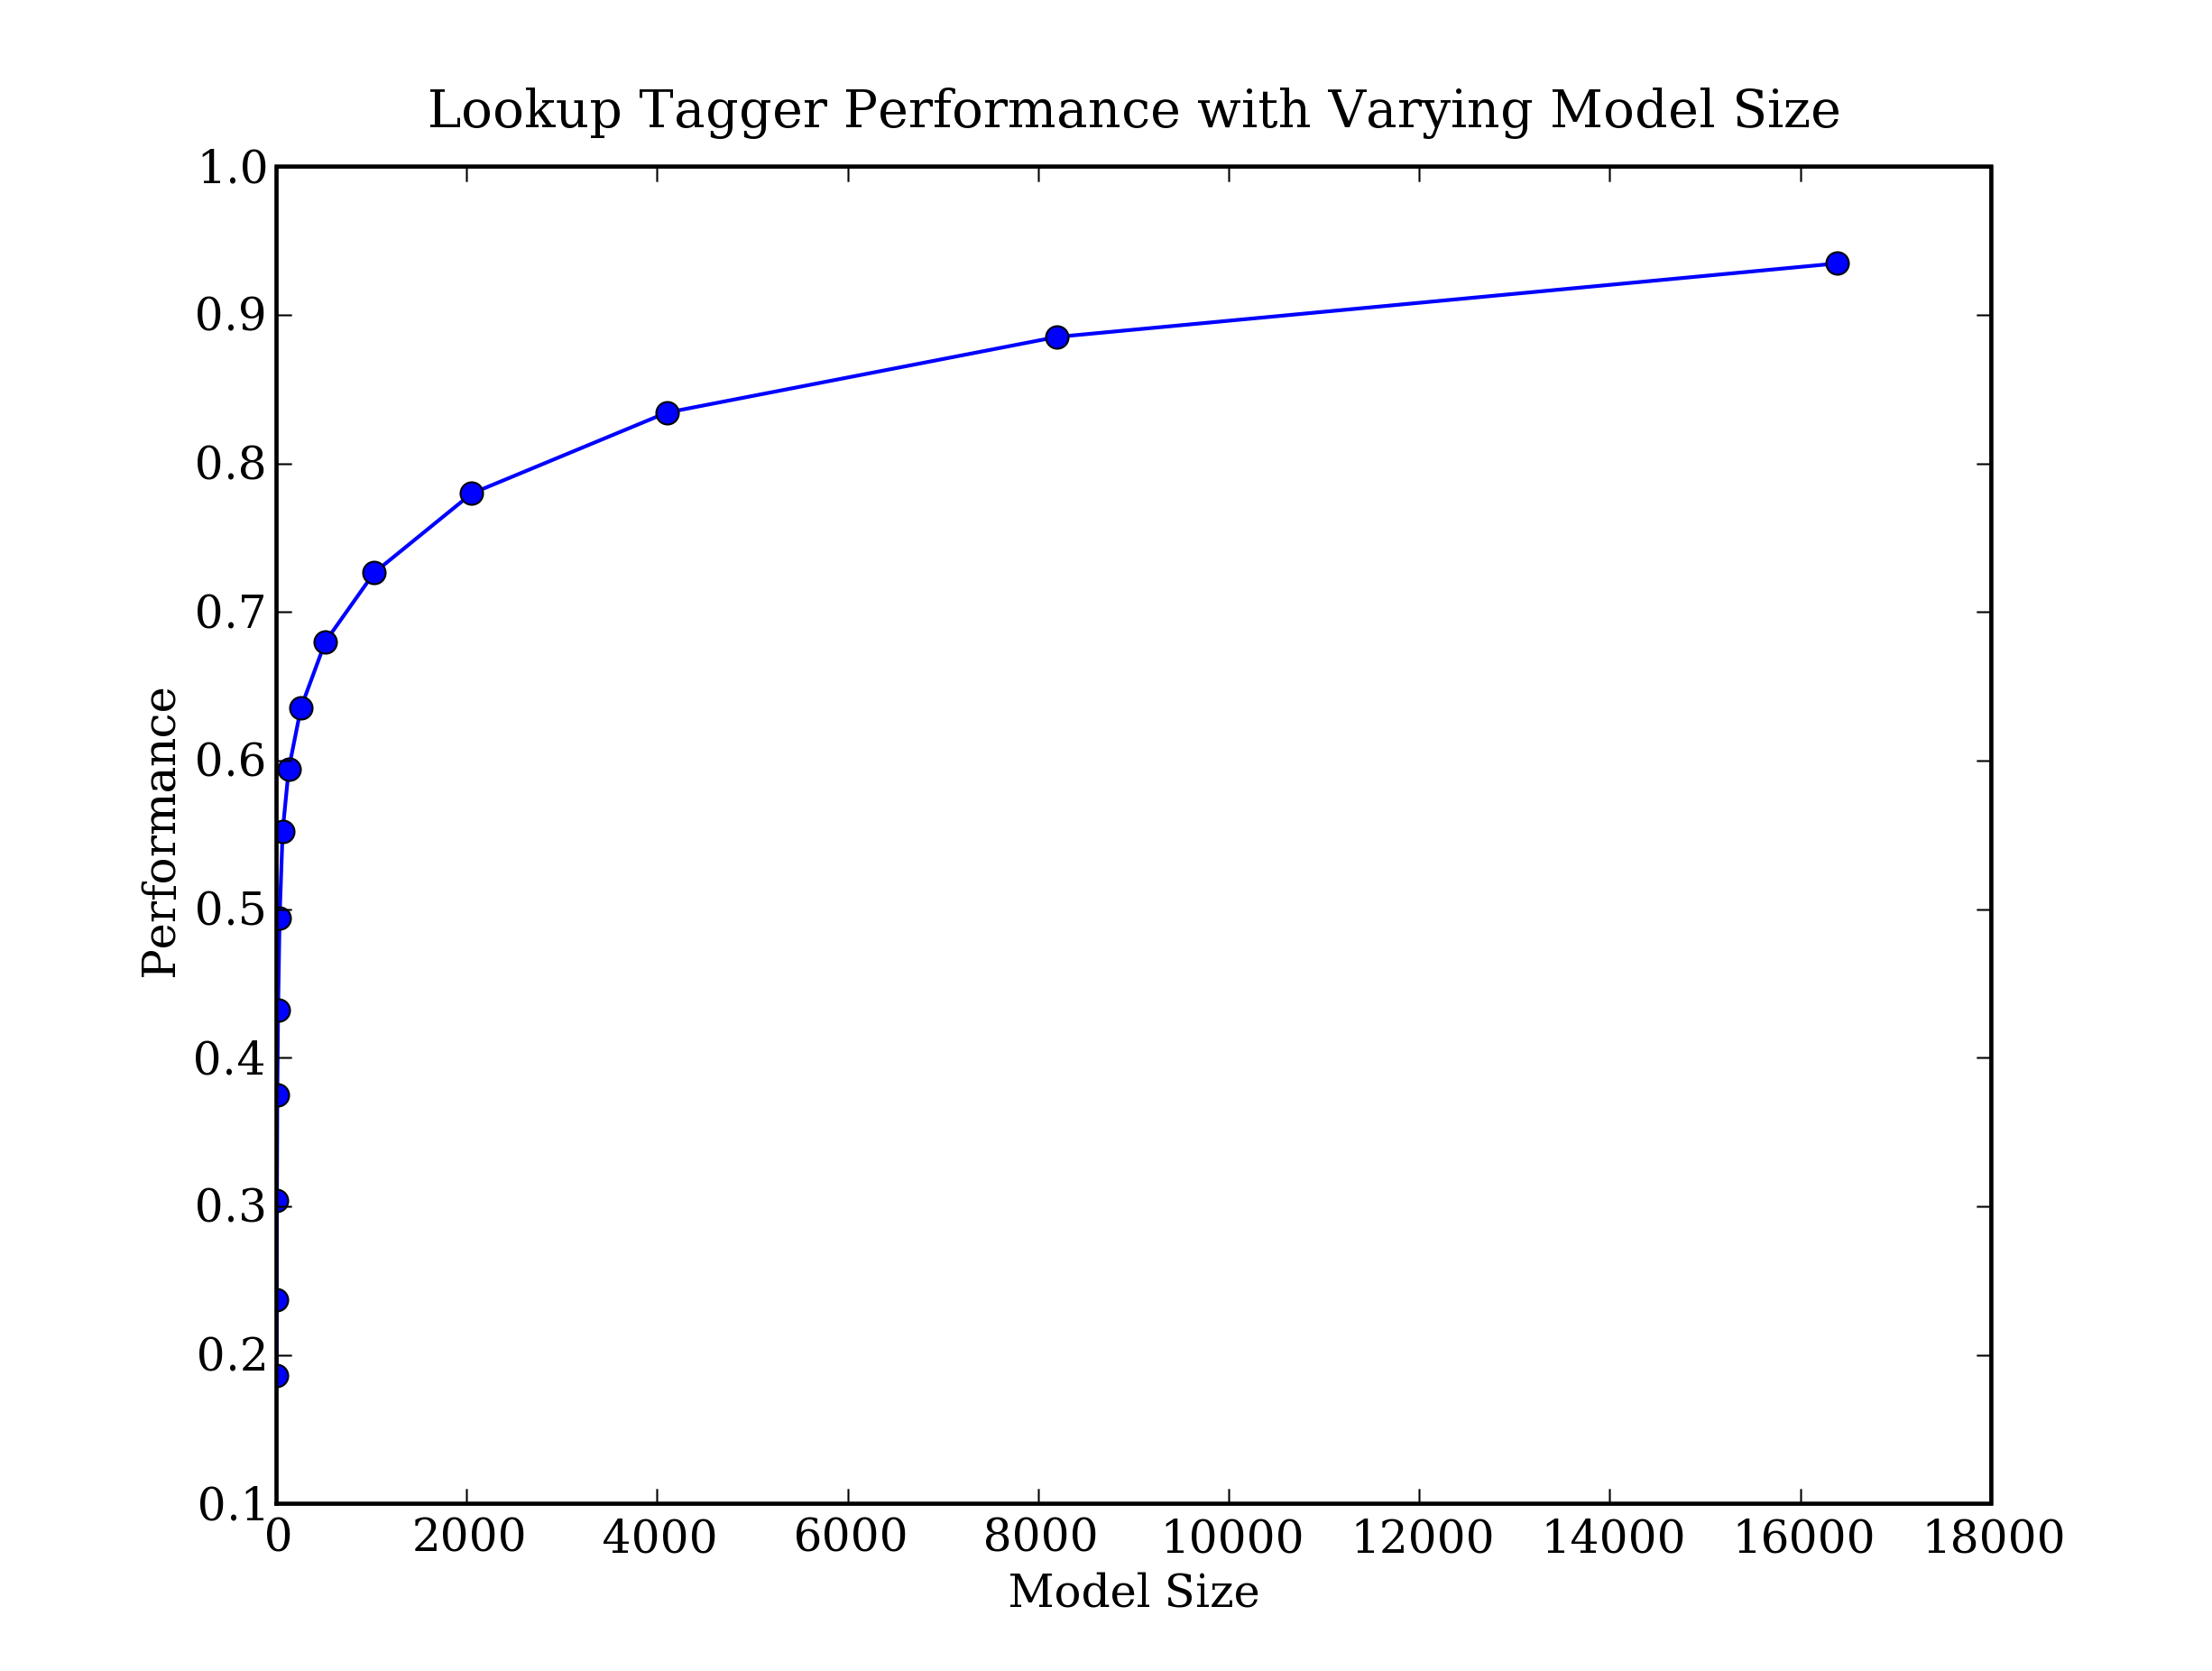

图 4.2：查找标注器

可以观察到，随着模型规模的增长，最初的性能增加迅速，最终达到一个稳定水平，这时模型的规模大量增加性能的提高很小。（这个例子使用`pylab`绘图软件包，在[4.8](https://usyiyi.github.io/nlp-py-2e-zh/4.html#sec-libraries)讨论过）。

## 4.4 评估

在前面的例子中，你会注意到对准确性得分的强调。事实上，评估这些工具的表现是NLP的一个中心主题。回想[fig-sds](https://usyiyi.github.io/nlp-py-2e-zh/1.html#fig-sds)中的处理流程；一个模块输出中的任何错误都在下游模块大大的放大。

我们对比人类专家分配的标记来评估一个标注器的表现。由于我们通常很难获得专业和公正的人的判断，所以使用黄金标准测试数据来代替。这是一个已经手动标注并作为自动系统评估标准而被接受的语料库。当标注器对给定词猜测的标记与黄金标准标记相同，标注器被视为是正确的。

当然，设计和实施原始的黄金标准标注的也是人。更深入的分析可能会显示黄金标准中的错误，或者可能最终会导致一个修正的标记集和更复杂的指导方针。然而，黄金标准就目前有关的自动标注器的评估而言被定义成“正确的”。

注意

开发一个已标注语料库是一个重大的任务。除了数据，它会产生复杂的工具、文档和实践，为确保高品质的标注。标记集和其他编码方案不可避免地依赖于一些理论主张，不是所有的理论主张都被共享，然而，语料库的创作者往往竭尽全力使他们的工作尽可能理论中立，以最大限度地提高其工作的有效性。我们将在[11.](https://usyiyi.github.io/nlp-py-2e-zh/ch11.html#chap-data)讨论创建一个语料库的挑战。

## 5 N-gram标注



<a href="#51-—元标注">5.1 —元标注</a>

<a href="#52-分离训练和测试数据">5.2 分离训练和测试数据</a>

<a href="#53-一般的n-gram标注">5.3 —般的N-gram标注</a>

<a href="#54-组合标注器">5.4 组合标注器</a>

<a href="#55-标注生词">5.5 标注生词</a>

<a href="#56-存储标注器">5.6 存储标注器</a>

<a href="#57-准确性的极限">5.7 准确性的极限</a>



## 5.1 一元标注

一元标注器基于一个简单的统计算法：对每个标识符分配这个独特的标识符最有可能的标记。例如，它将分配标记`JJ`给词frequent的所有出现，因为frequent用作一个形容词（例如a frequent word）比用作一个动词（例如I frequent this cafe）更常见。一个一元标注器的行为就像一个查找标注器（[4](https://usyiyi.github.io/nlp-py-2e-zh/5.html#sec-automatic-tagging)），除了有一个更方便的建立它的技术，称为训练。在下面的代码例子中，我们训练一个一元标注器，用它来标注一个句子，然后评估：

In [63]:
from nltk.corpus import brown
brown_tagged_sents = brown.tagged_sents(categories='news')
brown_sents = brown.sents(categories='news')
unigram_tagger = nltk.UnigramTagger(brown_tagged_sents)
unigram_tagger.tag(brown_sents[2007])

[('Various', 'JJ'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('apartments', 'NNS'),
 ('are', 'BER'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('terrace', 'NN'),
 ('type', 'NN'),
 (',', ','),
 ('being', 'BEG'),
 ('on', 'IN'),
 ('the', 'AT'),
 ('ground', 'NN'),
 ('floor', 'NN'),
 ('so', 'QL'),
 ('that', 'CS'),
 ('entrance', 'NN'),
 ('is', 'BEZ'),
 ('direct', 'JJ'),
 ('.', '.')]

In [65]:
# unigram_tagger.evaluate(brown_tagged_sents)
unigram_tagger.accuracy(brown_tagged_sents)

0.9349006503968017

我们训练一个`UnigramTagger`，通过在我们初始化标注器时指定已标注的句子数据作为参数。训练过程中涉及检查每个词的标记，将所有词的最可能的标记存储在一个字典里面，这个字典存储在标注器内部。

## 5.2 分离训练和测试数据

现在，我们正在一些数据上训练一个标注器，必须小心不要在相同的数据上测试，如我们在前面的例子中的那样。一个只是记忆它的训练数据，而不试图建立一个一般的模型的标注器会得到一个完美的得分，但在标注新的文本时将是无用的。相反，我们应该分割数据，90％为测试数据，其余10％为测试数据：

In [66]:
size = int(len(brown_tagged_sents) * 0.9)
size

4160

In [68]:
train_sents = brown_tagged_sents[:size]
test_sents = brown_tagged_sents[size:]
unigram_tagger = nltk.UnigramTagger(train_sents)
# unigram_tagger.evaluate(test_sents)
unigram_tagger.accuracy(test_sents)

0.8121200039868434

虽然得分更糟糕了，但是现在我们对这种标注器的用处有了更好的了解，如它在之前没有遇见的文本上的表现。

## 5.3 一般的N-gram标注

在基于一元处理一个语言处理任务时，我们使用上下文中的一个项目。标注的时候，我们只考虑当前的词符，与更大的上下文隔离。给定一个模型，我们能做的最好的是为每个词标注其*先验的*最可能的标记。这意味着我们将使用相同的标记标注一个词，如wind，不论它出现的上下文是the wind还是to wind。

一个n-gram tagger标注器是一个一元标注器的一般化，它的上下文是当前词和它前面*n*-1个标识符的词性标记，如图[5.1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#fig-tag-context)所示。要选择的标记是圆圈里的*t*n，灰色阴影的是上下文。在[5.1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#fig-tag-context)所示的n-gram标注器的例子中，我们让*n*=3；也就是说，我们考虑当前词的前两个词的标记。一个n-gram标注器挑选在给定的上下文中最有可能的标记。

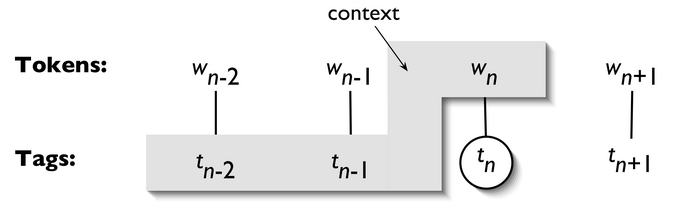)

图 5.1：标注器上下文

注意

1-gram标注器是一元标注器另一个名称：即用于标注一个词符的上下文的只是词符本身。2-gram标注器也称为*二元标注器*，3-gram标注器也称为*三元标注器*。

`NgramTagger`类使用一个已标注的训练语料库来确定对每个上下文哪个词性标记最有可能。这里我们看n-gram标注器的一个特殊情况，二元标注器。首先，我们训练它，然后用它来标注未标注的句子：

In [69]:
bigram_tagger = nltk.BigramTagger(train_sents)
bigram_tagger.tag(brown_sents[2007])

[('Various', 'JJ'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('apartments', 'NNS'),
 ('are', 'BER'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('terrace', 'NN'),
 ('type', 'NN'),
 (',', ','),
 ('being', 'BEG'),
 ('on', 'IN'),
 ('the', 'AT'),
 ('ground', 'NN'),
 ('floor', 'NN'),
 ('so', 'CS'),
 ('that', 'CS'),
 ('entrance', 'NN'),
 ('is', 'BEZ'),
 ('direct', 'JJ'),
 ('.', '.')]

In [70]:
unseen_sent = brown_sents[4203]
bigram_tagger.tag(unseen_sent)

[('The', 'AT'),
 ('population', 'NN'),
 ('of', 'IN'),
 ('the', 'AT'),
 ('Congo', 'NP'),
 ('is', 'BEZ'),
 ('13.5', None),
 ('million', None),
 (',', None),
 ('divided', None),
 ('into', None),
 ('at', None),
 ('least', None),
 ('seven', None),
 ('major', None),
 ('``', None),
 ('culture', None),
 ('clusters', None),
 ("''", None),
 ('and', None),
 ('innumerable', None),
 ('tribes', None),
 ('speaking', None),
 ('400', None),
 ('separate', None),
 ('dialects', None),
 ('.', None)]

请注意，二元标注器能够标注训练中它看到过的句子中的所有词，但对一个没见过的句子表现很差。只要遇到一个新词（如13.5），就无法给它分配标记。它不能标注下面的词（如million)，即使是在训练过程中看到过的，只是因为在训练过程中从来没有见过它前面有一个`None`标记的词。因此，标注器标注句子的其余部分也失败了。它的整体准确度得分非常低：

In [72]:
# bigram_tagger.evaluate(test_sents)
bigram_tagger.accuracy(test_sents)

0.10206319146815508

当*n*越大，上下文的特异性就会增加，我们要标注的数据中包含训练数据中不存在的上下文的几率也增大。这被称为*数据稀疏*问题，在NLP中是相当普遍的。因此，我们的研究结果的精度和覆盖范围之间需要有一个权衡（这与信息检索中的精度/召回权衡有关）。

小心！

N-gram标注器不应考虑跨越句子边界的上下文。因此，NLTK的标注器被设计用于句子列表，其中一个句子是一个词列表。在一个句子的开始，*t*n-1和前面的标记被设置为`None`。

## 5.4 组合标注器

解决精度和覆盖范围之间的权衡的一个办法是尽可能的使用更精确的算法，但却在很多时候落后于具有更广覆盖范围的算法。例如，我们可以按如下方式组合二元标注器、一元注器和一个默认标注器，如下：

1. 尝试使用二元标注器标注标识符。
2. 如果二元标注器无法找到一个标记，尝试一元标注器。
3. 如果一元标注器也无法找到一个标记，使用默认标注器。

大多数NLTK标注器允许指定一个回退标注器。回退标注器自身可能也有一个回退标注器：

In [74]:
t0 = nltk.DefaultTagger('NN')
t1 = nltk.UnigramTagger(train_sents, backoff=t0)
t2 = nltk.BigramTagger(train_sents, backoff=t1)
# t2.evaluate(test_sents)
t2.accuracy(test_sents)

0.8452108043456593

注意

**轮到你来：** 通过定义一个名为`t3`的`TrigramTagger`，扩展前面的例子，它是`t2`的回退标注器。

请注意，我们在标注器初始化时指定回退标注器，从而使训练能利用回退标注器。于是，在一个特定的上下文中，如果二元标注器将分配与它的一元回退标注器一样的标记，那么二元标注器丢弃训练的实例。这样保持尽可能小的二元标注器模型。我们可以进一步指定一个标注器需要看到一个上下文的多个实例才能保留它，例如`nltk.BigramTagger(sents, cutoff=2, backoff=t1)`将会丢弃那些只看到一次或两次的上下文。

## 5.5 标注生词

我们标注生词的方法仍然是回退到一个正则表达式标注器或一个默认标注器。这些都无法利用上下文。因此，如果我们的标注器遇到词blog，训练过程中没有看到过，它会分配相同的标记，不论这个词出现的上下文是the blog还是to blog。我们怎样才能更好地处理这些生词，或词汇表以外的项目？

一个有用的基于上下文标注生词的方法是限制一个标注器的词汇表为最频繁的n 个词，使用 [3](https://usyiyi.github.io/nlp-py-2e-zh/5.html#sec-dictionaries)中的方法替代每个其他的词为一个特殊的词UNK。训练时，一个一元标注器可能会学到UNK通常是一个名词。然而，n-gram标注器会检测它的一些其他标记中的上下文。例如，如果前面的词是to（标注为`TO`），那么UNK可能会被标注为一个动词。

## 5.6 存储标注器

在大语料库上训练一个标注器可能需要大量的时间。没有必要在每次我们需要的时候训练一个标注器，很容易将一个训练好的标注器保存到一个文件以后重复使用。让我们保存我们的标注器`t2`到文件`t2.pkl`。

In [75]:
from pickle import dump
output = open('t2.pkl', 'wb')
dump(t2, output, -1)
output.close()

现在，我们可以在一个单独的Python进程中，我们可以载入保存的标注器。

In [76]:
from pickle import load
input = open('t2.pkl', 'rb')
tagger = load(input)
input.close()

现在让我们检查它是否可以用来标注。

In [77]:
text = """The board's action shows what free enterprise
   is up against in our complex maze of regulatory laws ."""
tokens = text.split()
tagger.tag(tokens)

[('The', 'AT'),
 ("board's", 'NN$'),
 ('action', 'NN'),
 ('shows', 'NNS'),
 ('what', 'WDT'),
 ('free', 'JJ'),
 ('enterprise', 'NN'),
 ('is', 'BEZ'),
 ('up', 'RP'),
 ('against', 'IN'),
 ('in', 'IN'),
 ('our', 'PP$'),
 ('complex', 'JJ'),
 ('maze', 'NN'),
 ('of', 'IN'),
 ('regulatory', 'NN'),
 ('laws', 'NNS'),
 ('.', '.')]

## 5.7 准确性的极限

一个n-gram标注器准确性的上限是什么？考虑一个三元标注器的情况。它遇到多少词性歧义的情况？我们可以根据经验决定这个问题的答案：

In [78]:
cfd = nltk.ConditionalFreqDist(
          ((x[1], y[1], z[0]), z[1])
          for sent in brown_tagged_sents
          for x, y, z in nltk.trigrams(sent))
ambiguous_contexts = [c for c in cfd.conditions() if len(cfd[c]) > 1]
sum(cfd[c].N() for c in ambiguous_contexts) / cfd.N()

0.049297702068029296

因此，1/20的三元是有歧义的[示例]。给定当前单词及其前两个标记，根据训练数据，在5％的情况中，有一个以上的标记可能合理地分配给当前词。假设我们总是挑选在这种含糊不清的上下文中最有可能的标记，可以得出三元标注器准确性的一个下界。

调查标注器准确性的另一种方法是研究它的错误。有些标记可能会比别的更难分配，可能需要专门对这些数据进行预处理或后处理。一个方便的方式查看标注错误是混淆矩阵。它用图表表示期望的标记（黄金标准）与实际由标注器产生的标记：

In [ ]:
test_tags = [tag for sent in brown.sents(categories='editorial')
                 for (word, tag) in t2.tag(sent)]
gold_tags = [tag for (word, tag) in brown.tagged_words(categories='editorial')]
print(nltk.ConfusionMatrix(gold_tags, test_tags))         

基于这样的分析，我们可能会决定修改标记集。或许标记之间很难做出的区分可以被丢弃，因为它在一些较大的处理任务的上下文中并不重要。

分析标注器准确性界限的另一种方式来自人类标注者之间并非100％的意见一致。[更多]

一般情况下，标注过程会损坏区别：例如当所有的人称代词被标注为`PRP`时，词的特性通常会失去。与此同时，标注过程引入了新的区别从而去除了含糊之处：例如deal标注为`VB`或`NN`。这种消除某些区别并引入新的区别的特点是标注的一个重要的特征，有利于分类和预测。当我们引入一个标记集的更细的划分时，在n-gram标注器决定什么样的标记分配给一个特定的词时，可以获得关于左侧上下文的更详细的信息。然而，标注器同时也将需要做更多的工作来划分当前的词符，只是因为有更多可供选择的标记。相反，使用较少的区别（如简化的标记集），标注器有关上下文的信息会减少，为当前词符分类的选择范围也较小。

我们已经看到，训练数据中的歧义导致标注器准确性的上限。有时更多的上下文能解决这些歧义。然而，在其他情况下，如[(Church, Young, & Bloothooft, 1996)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#abney1996pst)中指出的，只有参考语法或现实世界的知识，才能解决歧义。尽管有这些缺陷，词性标注在用统计方法进行自然语言处理的兴起过程中起到了核心作用。1990年代初，统计标注器令人惊讶的精度是一个惊人的示范，可以不用更深的语言学知识解决一小部分语言理解问题，即词性消歧。这个想法能再推进吗？第[7.](https://usyiyi.github.io/nlp-py-2e-zh/7.html#chap-chunk)中，我们将看到，它可以。

## 6 基于转换的标注

n-gram标注器的一个潜在的问题是它们的n-gram表（或语言模型）的大小。如果使用各种语言技术的标注器部署在移动计算设备上，在模型大小和标注器准确性之间取得平衡是很重要的。使用回退标注器的n-gram标注器可能存储trigram和bigram表，这是很大的稀疏阵列，可能有数亿条条目。

第二个问题是关于上下文。n-gram标注器从前面的上下文中获得的唯一的信息是标记，虽然词本身可能是一个有用的信息源。n-gram模型使用上下文中的词的其他特征为条件是不切实际的。在本节中，我们考察Brill标注，一种归纳标注方法，它的性能很好，使用的模型只有n-gram标注器的很小一部分。

Brill标注是一种*基于转换的学习*，以它的发明者命名。一般的想法很简单：猜每个词的标记，然后返回和修复错误。在这种方式中，Brill标注器陆续将一个不良标注的文本转换成一个更好的。与n-gram标注一样，这是有*监督的学习*方法，因为我们需要已标注的训练数据来评估标注器的猜测是否是一个错误。然而，不像n-gram标注，它不计数观察结果，只编制一个转换修正规则列表。

Brill标注的的过程通常是与绘画类比来解释的。假设我们要画一棵树，包括大树枝、树枝、小枝、叶子和一个统一的天蓝色背景的所有细节。不是先画树然后尝试在空白处画蓝色，而是简单的将整个画布画成蓝色，然后通过在蓝色背景上上色“修正”树的部分。以同样的方式，我们可能会画一个统一的褐色的树干再回过头来用更精细的刷子画进一步的细节。Brill标注使用了同样的想法：以大笔画开始，然后修复细节，一点点的细致的改变。让我们看看下面的例子：

In [86]:
from nltk.tbl import demo as brill_tagger
brill_tagger.demo()

# nltk.tag.brill.demo() # 源代码无效，应导入 nltk.tbl 的 demo
# https://github.com/nltk/nltk/issues/1828

Loading tagged data from treebank... 
Read testing data (200 sents/5251 wds)
Read training data (800 sents/19933 wds)
Read baseline data (800 sents/19933 wds) [reused the training set]
Trained baseline tagger
    Accuracy on test set: 0.8358
Training tbl tagger...
TBL train (fast) (seqs: 800; tokens: 19933; tpls: 24; min score: 3; min acc: None)
Finding initial useful rules...
    Found 12799 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
  23  23   0   0  | POS->VBZ if Pos:PRP@[-2,-1]
  18  19   1   0  | NN->VB if Pos:-NONE-@[-2] & Pos:TO@[-1]
  14  14   0   0  | VBP->VB if Pos:MD@[-2,-1]
  12  12   0   0  | VBP->VB if Pos:TO@[-1]
  

In [ ]:
print(open("errors.out").read()) # 如果没有生成 erroes.out 就不用执行

## 7 如何确定一个词的分类

我们已经详细研究了词类，现在转向一个更基本的问题：我们如何首先决定一个词属于哪一类？在一般情况下，语言学家使用形态学、句法和语义线索确定一个词的类别。

## 7.1 形态学线索

一个词的内部结构可能为这个词分类提供有用的线索。举例来说：-ness是一个后缀，与形容词结合产生一个名词，如happy → happiness, ill → illness。如果我们遇到的一个以-ness结尾的词，很可能是一个名词。同样的，-ment是与一些动词结合产生一个名词的后缀，如govern → government和establish → establishment。

英语动词也可以是形态复杂的。例如，一个动词的现在分词以-ing结尾，表示正在进行的还没有结束的行动（如falling, eating）。-ing后缀也出现在从动词派生的名词中，如the falling of the leaves（这被称为动名词）。

## 7.2 句法线索

另一个信息来源是一个词可能出现的典型的上下文语境。例如，假设我们已经确定了名词类。那么我们可以说，英语形容词的句法标准是它可以立即出现在一个名词前，或紧跟在词be或very后。根据这些测试，near应该被归类为形容词：

```
Statement  User117 Dude, I wanted some of that
ynQuestion User120 m I missing something?
Bye        User117 I'm gonna go fix food, I'll be back later.
System     User122 JOIN
System     User2   slaps User122 around a bit with a large trout.
Statement  User121 18/m pm me if u tryin to chat
```

## 10 练习

1. ☼ 网上搜索“spoof newspaper headlines”，找到这种宝贝：British Left Waffles on Falkland Islands和Juvenile Court to Try Shooting Defendant。手工标注这些头条，看看词性标记的知识是否可以消除歧义。

2. ☼ 和别人一起，轮流挑选一个既可以是名词也可以是动词的词（如contest）；让对方预测哪一个可能是布朗语料库中频率最高的；检查对方的预测，为几个回合打分。

3. ☼ 分词和标注下面的句子：They wind back the clock, while we chase after the wind。涉及哪些不同的发音和词类？

4. ☼ 回顾[3.1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#tab-linguistic-objects)中的映射。讨论你能想到的映射的其他的例子。它们从什么类型的信息映射到什么类型的信息？

5. ☼ 在交互模式下使用Python解释器，实验本章中字典的例子。创建一个字典`d`，添加一些条目。如果你尝试访问一个不存在的条目会发生什么，如`d['xyz']`？

6. ☼ 尝试从字典`d`删除一个元素，使用语法`del d['abc']`。检查被删除的项目。

7. ☼ 创建两个字典，`d1`和`d2`，为每个添加一些条目。现在发出命令`d1.update(d2)`。这做了什么？它可能是有什么用？

8. ☼ 创建一个字典`e`，表示你选择的一些词的一个单独的词汇条目。定义键如`headword`、`part-of-speech`、`sense`和`example`，分配给它们适当的值。

9. ☼ 自己验证go和went在分布上的限制，也就是说，它们不能自由地在[7](https://usyiyi.github.io/nlp-py-2e-zh/5.html#sec-how-to-determine-the-category-of-a-word)中的[(3d)](https://usyiyi.github.io/nlp-py-2e-zh/5.html#ex-go)演示的那种上下文中互换。

10. ☼ 训练一个一元标注器，在一些新的文本上运行。观察有些词没有分配到标记。为什么没有？

11. ☼ 了解词缀标注器（输入`help(nltk.AffixTagger)`）。训练一个词缀标注器，在一些新的文本上运行。设置不同的词缀长度和最小词长做实验。讨论你的发现。

12. ☼ 训练一个没有回退标注器的二元标注器，在一些训练数据上运行。下一步，在一些新的数据运行它。标注器的准确性会发生什么？为什么呢？

13. ☼ 我们可以使用字典指定由一个格式化字符串替换的值。阅读关于格式化字符串的Python库文档`http://docs.python.org/lib/typesseq-strings.html`，使用这种方法以两种不同的格式显示今天的日期。

14. ◑ 使用`sorted()`和`set()`获得布朗语料库使用的标记的排序的列表，删除重复。

15. ◑ 写程序处理布朗语料库，找到以下问题的答案：

1. 哪些名词常以它们复数形式而不是它们的单数形式出现？（只考虑常规的复数形式，-s后缀形式的）。
2. 哪个词的不同标记数目最多。它们是什么，它们代表什么？
3. 按频率递减的顺序列出标记。前20个最频繁的标记代表什么？
4. 名词后面最常见的是哪些标记？这些标记代表什么？

16. ◑ 探索有关查找标注器的以下问题：

1. 回退标注器被省略时，模型大小变化，标注器的准确性会发生什么？
2. 思考[4.2](https://usyiyi.github.io/nlp-py-2e-zh/5.html#fig-tag-lookup)的曲线；为查找标注器推荐一个平衡内存和准确性的好的规模。你能想出在什么情况下应该尽量减少内存使用，什么情况下性能最大化而不必考虑内存使用？

17. ◑ 查找标注器的准确性上限是什么，假设其表的大小没有限制？（提示：写一个程序算出被分配了最有可能的标记的词的词符的平均百分比。）

18. ◑ 生成已标注数据的一些统计数据，回答下列问题：

1. 总是被分配相同词性的词类的比例是多少？
2. 多少词是有歧义的，从某种意义上说，它们至少和两个标记一起出现？
3. 布朗语料库中这些有歧义的词的*词符*的百分比是多少？

19. ◑ `evaluate()`方法算出一个文本上运行的标注器的精度。

例如，如果提供的已标注文本是`[('the', 'DT'), ('dog', 'NN')]`，标注器产生的输出是`[('the', 'NN'), ('dog', 'NN')]`，那么得分为`0.5`。

让我们尝试找出评价方法是如何工作的：

1. 一个标注器`t`将一个词汇列表作为输入，产生一个已标注词列表作为输出。然而，`t.evaluate()`只以一个正确标注的文本作为唯一的参数。执行标注之前必须对输入做些什么？
2. 一旦标注器创建了新标注的文本，`evaluate()` 方法可能如何比较它与原来标注的文本，计算准确性得分？
3. 现在，检查源代码来看看这个方法是如何实现的。检查`nltk.tag.api.__file__`找到源代码的位置，使用编辑器打开这个文件（一定要使用文件`api.py`，而不是编译过的二进制文件`api.pyc`）。

20. ◑ 编写代码，搜索布朗语料库，根据标记查找特定的词和短语，回答下列问题：

1. 产生一个标注为`MD`的不同的词的按字母顺序排序的列表。
2. 识别可能是复数名词或第三人称单数动词的词（如deals, flies）。
3. 识别三个词的介词短语形式IN + DET + NN（如in the lab）。
4. 男性与女性代词的比例是多少？

21. ◑ 在[3.1](https://usyiyi.github.io/nlp-py-2e-zh/3.html#tab-absolutely)中我们看到动词adore, love, like, prefer及前面的限定符absolutely和definitely的频率计数的表格。探讨这四个动词前出现的所有限定符。

22. ◑ 我们定义可以用来做生词的回退标注器的`regexp_tagger`。这个标注器只检查基数词。通过特定的前缀或后缀字符串进行测试，它应该能够猜测其他标记。例如，我们可以标注所有-s结尾的词为复数名词。定义一个正则表达式标注器（使用`RegexpTagger()`），测试至少5 个单词拼写的其他模式。（使用内联文档解释规则。）

23. ◑ 考虑上一练习中开发的正则表达式标注器。使用它的`accuracy()`方法评估标注器，尝试想办法提高其性能。讨论你的发现。客观的评估如何帮助开发过程？

24. ◑ 数据稀疏问题有多严重？调查n-gram 标注器当n从1增加到6时的准确性。为准确性得分制表。估计这些标注器需要的训练数据，假设词汇量大小为105而标记集的大小为102。

25. ◑ 获取另一种语言的一些已标注数据，在其上测试和评估各种标注器。如果这种语言是形态复杂的，或者有词类的任何字形线索（如），可以考虑为它开发一个正则表达式标注器（排在一元标注器之后，默认标注器之前）。对比同样的运行在英文数据上的标注器，你的标注器的准确性如何？讨论你在运用这些方法到这种语言时遇到的问题。

26. ◑ [4.1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#code-baseline-tagger)绘制曲线显示查找标注器的性能随模型的大小增加的变化。绘制当训练数据量变化时一元标注器的性能曲线。

27. ◑ 检查[5](https://usyiyi.github.io/nlp-py-2e-zh/5.html#sec-n-gram-tagging)中定义的二元标注器`t2`的混淆矩阵，确定简化的一套或多套标记。定义字典做映射，在简化的数据上评估标注器。

28. ◑ 使用简化的标记集测试标注器（或制作一个你自己的，通过丢弃每个标记名中除第一个字母外所有的字母）。这种标注器需要做的区分更少，但由它获得的信息也更少。讨论你的发现。

29. ◑ 回顾一个二元标注器训练过程中遇到生词，标注句子的其余部分为`None`的例子。一个二元标注器可能只处理了句子的一部分就失败了，即使句子中没有包含生词（即使句子在训练过程中使用过）。在什么情况下会出现这种情况呢？你可以写一个程序，找到一些这方面的例子吗？

30. ◑ 预处理布朗新闻数据，替换低频词为UNK，但留下标记不变。在这些数据上训练和评估一个二元标注器。这样有多少帮助？一元标注器和默认标注器的贡献是什么？

31. ◑ 修改[4.1](https://usyiyi.github.io/nlp-py-2e-zh/5.html#code-baseline-tagger)中的程序，通过将`pylab.plot()`替换为`pylab.semilogx()`，在*x*轴上使用对数刻度。关于结果图形的形状，你注意到了什么？梯度告诉你什么呢？

32. ◑ 使用`help(nltk.tag.brill.demo)`阅读Brill标注器演示函数的文档。通过设置不同的参数值试验这个标注器。是否有任何训练时间（语料库大小）和性能之间的权衡？

33. ◑ 写代码构建一个集合的字典的字典。用它来存储一套可以跟在具有给定词性标记的给定词后面的词性标记，例如wordi → tagi → tagi+1。

34. ★ 布朗语料库中有264个不同的词有3种可能的标签。

1. 打印一个表格，一列中是整数1..10，另一列是语料库中有1..10个不同标记的不同词的数目。
2. 对有不同的标记数量最多的词，输出语料库中包含这个词的句子，每个可能的标记一个。

35. ★ 写一个程序，按照词must后面的词的标记为它的上下文分类。这样可以区分must的“必须”和“应该”两种词意上的用法吗？

36. ★ 创建一个正则表达式标注器和各种一元以及n-gram标注器，包括回退，在布朗语料库上训练它们。

1. 创建这些标注器的3种不同组合。测试每个组合标注器的准确性。哪种组合效果最好？
2. 尝试改变训练语料的规模。它是如何影响你的结果的？

37. ★ 我们标注生词的方法一直要考虑这个词的字母（使用`RegexpTagger()`），或完全忽略这个词，将它标注为一个名词（使用`nltk.DefaultTagger()`）。

这些方法对于有新词却不是名词的文本不会很好。

思考句子I like to blog on Kim's blog。

如果blog是一个新词，那么查看前面的标记（`TO`和`NP$`）可能会有所帮助。

即

我们需要一个对前面的标记敏感的默认标注器。

1. 创建一种新的一元标注器，查看前一个词的标记，而忽略当前词。（做到这一点的最好办法是修改`UnigramTagger()`的源代码，需要Python中的面向对象编程的知识。
2. 将这个标注器加入到回退标注器序列（包括普通的三元和二元标注器），放在常用默认标注器的前面。
3. 评价这个新的一元标注器的贡献。

38. ★ 思考[5](https://usyiyi.github.io/nlp-py-2e-zh/5.html#sec-n-gram-tagging)中的代码，它确定一个三元标注器的准确性上限。回顾Abney的关于精确标注的不可能性的讨论[(Church, Young, & Bloothooft, 1996)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#abney1996pst)。解释为什么正确标注这些例子需要获取词和标记以外的其他种类的信息。你如何估计这个问题的规模？

39. ★ 使用`nltk.probability`中的一些估计技术，例如*Lidstone*或*Laplace* 估计，开发一种统计标注器，它在训练中没有遇到而测试中遇到的上下文中表现优于n-gram回退标注器。

40. ★ 检查Brill标注器创建的诊断文件`rules.out`和`errors.out`。通过访问源代码（`http://www.nltk.org/code`）获得演示代码，创建你自己版本的Brill标注器。并根据你从检查`rules.out`了解到的，删除一些规则模板。增加一些新的规则模板，这些模板使用那些可能有助于纠正你在`errors.out`看到的错误的上下文。

41. ★ 开发一个n-gram回退标注器，允许在标注器初始化时指定“anti-n-grams”，如`["the", "the"]`。一个anti-n-grams被分配一个数字0，被用来防止这个n-gram回退（如避免估计P(the | the)而只做P(the)）。

42. ★ 使用布朗语料库开发标注器时，调查三种不同的方式来定义训练和测试数据之间的分割：genre (`category`)、source (`fileid`)和句子。比较它们的相对性能，并讨论哪种方法最合理。（你可能要使用n-交叉验证，在[3](https://usyiyi.github.io/nlp-py-2e-zh/6.html#sec-evaluation)中讨论的，以提高评估的准确性。）

43. ★ 开发你自己的`NgramTagger`，从NLTK中的类继承，封装本章中所述的已标注的训练和测试数据的词汇表缩减方法。确保一元和默认回退标注器有机会获得全部词汇。

关于本文档

UPDATED FOR NLTK 3.0. 本章来自于*Natural Language Processing with Python*，[Steven Bird](http://estive.net/), [Ewan Klein](http://homepages.inf.ed.ac.uk/ewan/) 和[Edward Loper](http://ed.loper.org/)，Copyright © 2014 作者所有。本章依据*Creative Commons Attribution-Noncommercial-No Derivative Works 3.0 United States License* [http://creativecommons.org/licenses/by-nc-nd/3.0/us/] 条款，与*自然语言工具包* [`http://nltk.org/`] 3.0 版一起发行。

本文档构建于星期三 2015 年 7 月 1 日 12:30:05 AEST